In [1]:
import pathlib

import numpy as np
import pandas as pd
import xarray as xr
from scipy import ndimage as ndi
from scipy.stats import binned_statistic, binned_statistic_2d, circmean, circstd
import pyproj

from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date

from tobac_flow.plotting import goes_figure, add_gl_ticks
from tobac_flow.analysis import apply_func_to_labels
from tobac_flow.abi import get_abi_rgb, get_abi_pixel_lengths, get_abi_lat_lon, get_abi_zenith_angle
from tobac_flow.utils import apply_func_to_labels


In [2]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
from matplotlib import patches
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [3]:
dpi=150
chapter_name = "chapter2"
save_format = "png"
save_path = pathlib.Path("../figures")
if not save_path.exists():
    save_path.mkdir()

figure_list = []

In [4]:
import os
os.environ["CARTOPY_USER_BACKGROUNDS"] = "/home/users/wkjones/data/cartopy_backgrounds"

In [5]:
dcc_path = pathlib.Path("../data/goes_statistics")
dcc_files = sorted(list(dcc_path.glob("dcc_statistics_G16_*.nc")))
print(len(dcc_files))
datasets = [xr.open_dataset(f) for f in dcc_files]

60


In [6]:
datasets[5]

<xarray.Dataset>
Dimensions:                                      (core: 92295, anvil: 15362,
                                                  core_step: 548172,
                                                  thick_anvil_step: 665700,
                                                  thin_anvil_step: 847482)
Coordinates:
  * core                                         (core) int32 30 34 ... 97267
  * anvil                                        (anvil) int32 3 81 ... 41455
  * core_step                                    (core_step) int32 14 ... 562512
  * thick_anvil_step                             (thick_anvil_step) int32 3 ....
  * thin_anvil_step                              (thin_anvil_step) int32 3 .....
    x_image                                      float32 ...
    y_image                                      float32 ...
Data variables: (12/142)
    core_edge_label_flag                         (core) int8 ...
    core_start_label_flag                        (core) int8 ...
    core_end_label_flag                          (core) int8 ...
    thick_anvil_edge_label_flag                  (anvil) int8 ...
    thick_anvil_start_label_flag                 (anvil) int8 ...
    thick_anvil_end_label_flag                   (anvil) int8 ...
    ...                                           ...
    anvil_core_count                             (anvil) int64 ...
    anvil_initial_core_index                     (anvil) int32 ...
    anvil_no_growth_flag                         (anvil) bool ...
    core_is_valid                                (core) bool ...
    thick_anvil_is_valid                         (anvil) bool ...
    thin_anvil_is_valid                          (anvil) bool ...

In [7]:
dcc_ds = xr.open_dataset(list(pathlib.Path("../data/chapter_2_data").glob("detected_dccs_G16_S20180619_120000_E20180620_120000_X0000_2500_Y0000_1500_processed.nc"))[0])
abi_ds = xr.open_dataset(sorted(list(pathlib.Path("../data/chapter_2_data").glob("OR_ABI-L2-MCMIPC-M3_G16_s20181701802246_e20181701805019_c20181701805135.nc")))[0])


In [8]:
dcc_ds

<xarray.Dataset>
Dimensions:                       (y: 1500, x: 2500, t: 288, core: 3428,
                                   anvil: 1209, core_step: 20383,
                                   thick_anvil_step: 54834,
                                   thin_anvil_step: 66041)
Coordinates:
  * t                             (t) datetime64[ns] 2018-06-19T12:03:43.1207...
  * y                             (y) float64 0.1282 0.1282 ... 0.04432 0.04427
  * x                             (x) float64 -0.1013 -0.1013 ... 0.03861
    x_image                       float32 ...
    y_image                       float32 ...
  * core                          (core) int32 53836 53853 53855 ... 57406 57407
  * anvil                         (anvil) int32 16707 21278 ... 26019 26020
  * core_step                     (core_step) int32 310115 310116 ... 330497
  * thick_anvil_step              (thick_anvil_step) int32 1036333 ... 1091166
  * thin_anvil_step               (thin_anvil_step) int32 1277210 ... 1343250
Data variables: (12/78)
    goes_imager_projection        int32 ...
    lat                           (y, x) float32 ...
    lon                           (y, x) float32 ...
    area                          (y, x) float32 ...
    core_label                    (t, y, x) int32 ...
    thick_anvil_label             (t, y, x) int32 ...
    ...                            ...
    thick_anvil_step_BT_max       (thick_anvil_step) float32 ...
    thick_anvil_step_BT_min       (thick_anvil_step) float32 ...
    thin_anvil_step_BT_mean       (thin_anvil_step) float32 ...
    thin_anvil_step_BT_std        (thin_anvil_step) float32 ...
    thin_anvil_step_BT_max        (thin_anvil_step) float32 ...
    thin_anvil_step_BT_min        (thin_anvil_step) float32 ...

In [9]:
abi_ds

<xarray.Dataset>
Dimensions:                                 (y: 1500, x: 2500,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float64 0.1282 ... 0.04427
  * x                                       (x) float64 -0.1013 ... 0.03861
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2018-06-19T18:05:13.5Z
    time_coverage_start:       2018-06-19T18:02:24.6Z
    time_coverage_end:         2018-06-19T18:05:01.9Z
    timeline_id:               ABI Mode 3
    production_data_source:    Realtime
    id:                        cd430480-7193-44f8-a2e2-463b9092f4c2

## Figure 1: ABI sensor zenith angle

In [10]:
def get_abi_zenith_angle(abi_ds):
    lat, lon = get_abi_lat_lon(abi_ds)
    dlat = np.deg2rad(lat - abi_ds.goes_imager_projection.latitude_of_projection_origin)
    dlon = np.deg2rad(lon - abi_ds.goes_imager_projection.longitude_of_projection_origin)

    surf_vectors = np.stack([
        np.cos(dlon) * np.sin(dlat),
        - np.sin(dlon),
        np.cos(dlon) * np.cos(dlat)
    ])
    xx, yy = np.meshgrid(-abi_ds.x, -abi_ds.y)

    abi_vectors = np.stack([
        np.cos(xx) * np.sin(yy),
        - np.sin(xx),
        np.cos(xx) * np.cos(yy)
    ])
    
    sza = np.rad2deg(np.arccos(np.sum(surf_vectors * abi_vectors, 0)))
    
    return sza

In [11]:
sza = get_abi_zenith_angle(abi_ds)

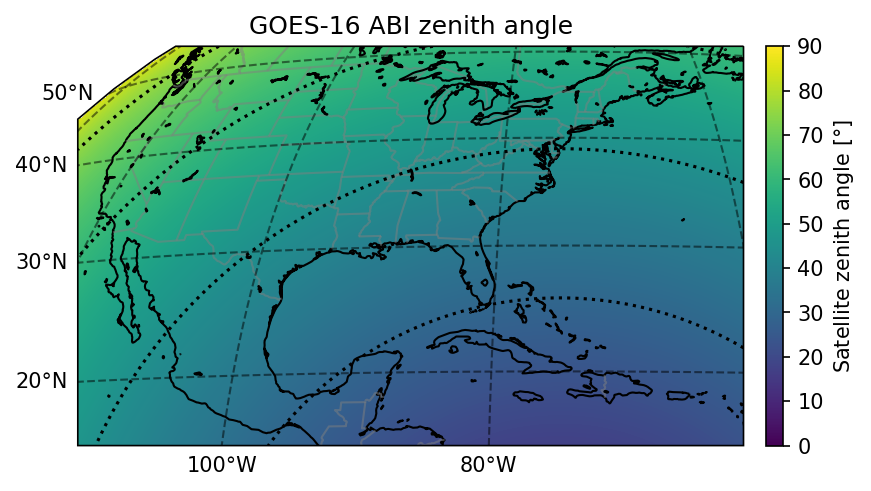

In [12]:
fig = goes_figure(dcc_ds, dpi=dpi)
ax = fig.subplot(111, cbar_size="2.5%", cbar_pad=0.15)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='k', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
# gl.xlines = False
# gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

img = ax.imshow(sza, vmin=0, vmax=90)
ax.colorbar(img, label="Satellite zenith angle [$\degree$]")
CS = ax.contour(sza, [30, 45, 60, 75], linestyles=":", colors="k")
# ax.clabel(CS, CS.levels, inline=True, fontsize=10)

ax.set_title("GOES-16 ABI zenith angle")

figure_list.append(plt.gcf())

## Figure 2 : example of core + anvil tracking

In [13]:
i = 72

thin_anvil_labels = np.isin(
    dcc_ds.thin_anvil_label[i],
    datasets[5].anvil[datasets[5].thin_anvil_is_valid]
)
thick_anvil_labels = np.isin(
    dcc_ds.thick_anvil_label[i],
    datasets[5].anvil[datasets[5].thin_anvil_is_valid]
)
core_labels = np.isin(
    dcc_ds.core_label[i],
    datasets[5].core[datasets[5].core_is_valid]
)

invalid_thin_anvil_labels = np.isin(
    dcc_ds.thin_anvil_label[i],
    datasets[5].anvil[np.logical_not(datasets[5].thin_anvil_is_valid)]
)
invalid_thick_anvil_labels = np.isin(
    dcc_ds.thick_anvil_label[i],
    datasets[5].anvil[np.logical_not(datasets[5].thin_anvil_is_valid)]
)
invalid_core_labels = np.isin(
    dcc_ds.core_label[i],
    datasets[5].core[np.logical_not(datasets[5].core_is_valid)]
)

removed_thin_anvil_labels = np.logical_and(
    np.logical_not(
        np.isin(dcc_ds.thin_anvil_label[i], datasets[5].anvil)
    ),
    dcc_ds.thin_anvil_label[i] != 0
)
removed_thick_anvil_labels = np.logical_and(
    np.logical_not(
        np.isin(dcc_ds.thick_anvil_label[i], datasets[5].anvil)
    ),
    dcc_ds.thick_anvil_label[i] != 0
)
removed_core_labels = np.logical_and(
    np.logical_not(
        np.isin(dcc_ds.core_label[i], datasets[5].core)
    ),
    dcc_ds.core_label[i] != 0
)

/var/folders/40/kfr98p0j7n30fjp2n4ljjqbh0000gr/T/ipykernel_1495/4101259841.py:82: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  fig.suptitle("Detected cores and anvils "+parse_date(dcc_ds.t.astype('datetime64[s]').data[i].astype(str)).strftime('%Y-%m-%d-%H:%M:%S')+" UTC")
/Users/jonesw/mambaforge-pypy3/envs/thesis_notebooks/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


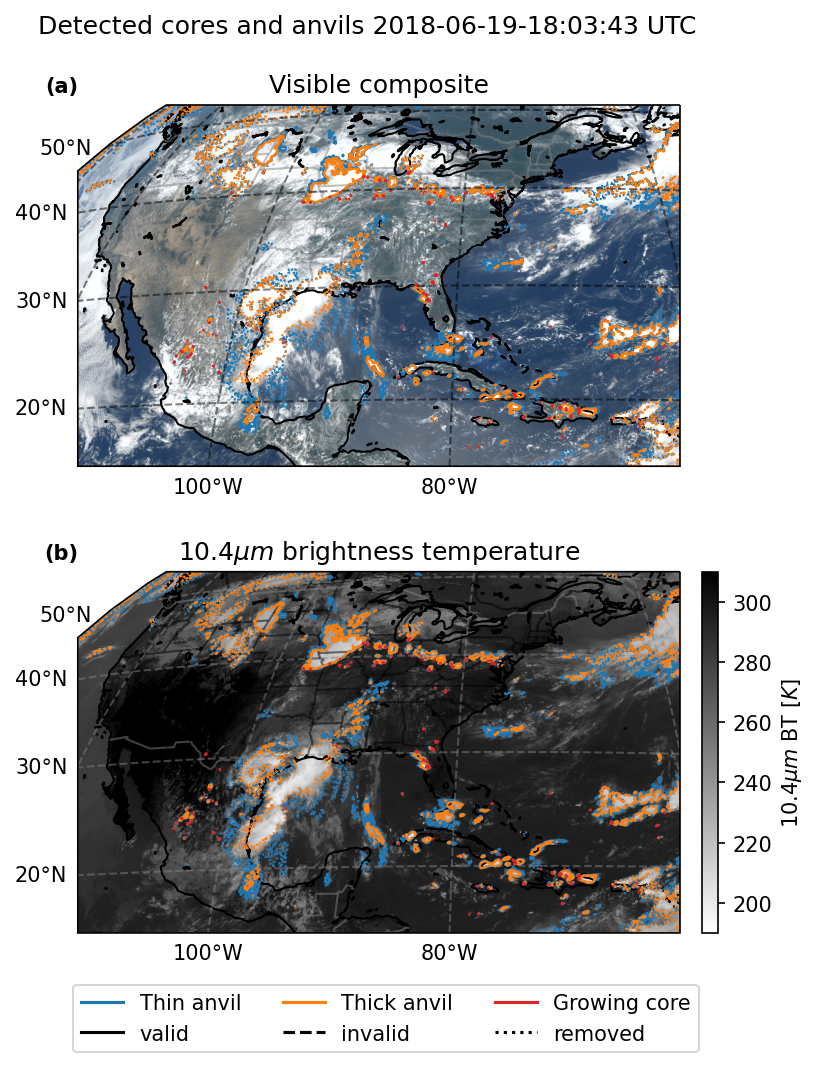

In [14]:
fig = goes_figure(dcc_ds, dpi=dpi, figsize=(6.4,7.2))
ax = fig.subplot(211, cbar_size="2.5%", cbar_pad=0.15)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='k', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
# gl.xlines = False
# gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# ax.background_img(name="bluemarble", resolution="high")

img = ax.imshow(get_abi_rgb(abi_ds)) 
cntr = [
    ax.contour(thin_anvil_labels, [0.5], colors=['C00'], linewidths=[1]),
    ax.contour(thick_anvil_labels, [0.5], colors=['C01'], linewidths=[1]),
    ax.contour(core_labels, [0.5], colors=['C03'], linewidths=[1]),
    ax.contour(invalid_thin_anvil_labels, [0.5], colors=['C00'], linewidths=[1], linestyles=["--"]),
    ax.contour(invalid_thick_anvil_labels, [0.5], colors=['C01'], linewidths=[1], linestyles=["--"]),
    ax.contour(invalid_core_labels, [0.5], colors=['C03'], linewidths=[1], linestyles=["--"]),
    ax.contour(removed_thin_anvil_labels, [0.5], colors=['C00'], linewidths=[1], linestyles=[":"]),
    ax.contour(removed_thick_anvil_labels, [0.5], colors=['C01'], linewidths=[1], linestyles=[":"]),
    ax.contour(removed_core_labels, [0.5], colors=['C03'], linewidths=[1], linestyles=[":"]),
]
ax.set_title("Visible composite")
ax.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=10)


ax = fig.subplot(212, cbar_size="2.5%", cbar_pad=0.15)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='k', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='k', alpha=1, facecolor="none")
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
# gl.xlines = False
# gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# ax.background_img(name="bluemarble", resolution="high")

img = ax.imshow(abi_ds.CMI_C13, cmap="binary", vmin=190, vmax=310)
cbar = ax.colorbar(img, label="10.4$\mu m$ BT [$K$]")
cntr = [
    ax.contour(thin_anvil_labels, [0.5], colors=['C00'], linewidths=[1]),
    ax.contour(thick_anvil_labels, [0.5], colors=['C01'], linewidths=[1]),
    ax.contour(core_labels, [0.5], colors=['C03'], linewidths=[1]),
    ax.contour(invalid_thin_anvil_labels, [0.5], colors=['C00'], linewidths=[1], linestyles=["--"]),
    ax.contour(invalid_thick_anvil_labels, [0.5], colors=['C01'], linewidths=[1], linestyles=["--"]),
    ax.contour(invalid_core_labels, [0.5], colors=['C03'], linewidths=[1], linestyles=["--"]),
    ax.contour(removed_thin_anvil_labels, [0.5], colors=['C00'], linewidths=[1], linestyles=[":"]),
    ax.contour(removed_thick_anvil_labels, [0.5], colors=['C01'], linewidths=[1], linestyles=[":"]),
    ax.contour(removed_core_labels, [0.5], colors=['C03'], linewidths=[1], linestyles=[":"]),
]
ax.set_title("10.4$\mu m$ brightness temperature")
ax.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=10)


# ax.set_title("Detected cores and anvils "+parse_date(dcc_ds.t.astype('datetime64[s]').data[i].astype(str)).strftime('%Y-%m-%d-%H:%M:%S')+" UTC")
fig.suptitle("Detected cores and anvils "+parse_date(dcc_ds.t.astype('datetime64[s]').data[i].astype(str)).strftime('%Y-%m-%d-%H:%M:%S')+" UTC")

plt.subplots_adjust(bottom=0.1, hspace=0.1, top=0.925)

legend = fig.legend(
    [
        mlines.Line2D([], [], color='C00'),
        mlines.Line2D([], [], color='k'),
        mlines.Line2D([], [], color='C01'), 
        mlines.Line2D([], [], color='k', linestyle="--"), 
        mlines.Line2D([], [], color='C03'),
        mlines.Line2D([], [], color='k', linestyle=":")
    ], 
    ['Thin anvil', "valid", 'Thick anvil', "invalid", 'Growing core', "removed"], 
    loc='center', ncol=3, bbox_to_anchor=[0.52, 0.05]
)

plt.draw()
# add_gl_ticks(ax, gl)

figure_list.append(plt.gcf())

In [15]:
def get_goes_crs_xy(goes_ds):
    h = goes_ds.goes_imager_projection.perspective_point_height
    return goes_ds.x.values * h, goes_ds.y.values * h

/var/folders/40/kfr98p0j7n30fjp2n4ljjqbh0000gr/T/ipykernel_1495/2629813985.py:101: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  fig.suptitle("Detected cores and anvils "+parse_date(dcc_ds.t.astype('datetime64[s]').data[i].astype(str)).strftime('%Y-%m-%d-%H:%M:%S')+" UTC")


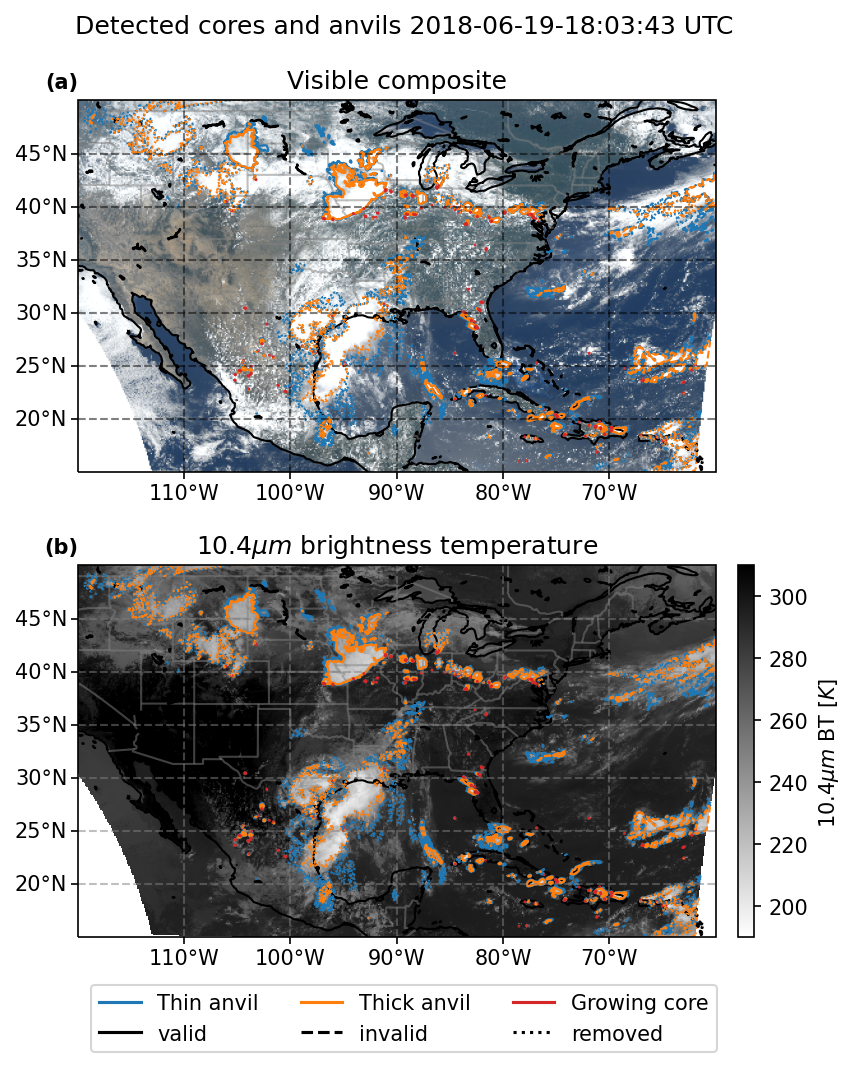

In [16]:
# Plot on PlateCarree projection
from tobac_flow.plotting import get_goes_ccrs, get_goes_extent

fig = plt.figure(dpi=dpi, figsize=(6.4,7.2))

ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax1.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax1.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax1.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='k', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

img = ax1.imshow(
    get_abi_rgb(abi_ds), 
    transform=get_goes_ccrs(abi_ds), extent=get_goes_extent(abi_ds), regrid_shape=1500
)

cntr = [
    ax1.contour(*get_goes_crs_xy(abi_ds), thin_anvil_labels, [0.5], colors=['C00'], linewidths=[1], transform=get_goes_ccrs(abi_ds)),
    ax1.contour(*get_goes_crs_xy(abi_ds), thick_anvil_labels, [0.5], colors=['C01'], linewidths=[1], transform=get_goes_ccrs(abi_ds)),
    ax1.contour(*get_goes_crs_xy(abi_ds), core_labels, [0.5], colors=['C03'], linewidths=[1], transform=get_goes_ccrs(abi_ds)),
    ax1.contour(*get_goes_crs_xy(abi_ds), invalid_thin_anvil_labels, [0.5], colors=['C00'], linewidths=[1], linestyles=["--"], transform=get_goes_ccrs(abi_ds)),
    ax1.contour(*get_goes_crs_xy(abi_ds), invalid_thick_anvil_labels, [0.5], colors=['C01'], linewidths=[1], linestyles=["--"], transform=get_goes_ccrs(abi_ds)),
    ax1.contour(*get_goes_crs_xy(abi_ds), invalid_core_labels, [0.5], colors=['C03'], linewidths=[1], linestyles=["--"], transform=get_goes_ccrs(abi_ds)),
    ax1.contour(*get_goes_crs_xy(abi_ds), removed_thin_anvil_labels, [0.5], colors=['C00'], linewidths=[1], linestyles=[":"], transform=get_goes_ccrs(abi_ds)),
    ax1.contour(*get_goes_crs_xy(abi_ds), removed_thick_anvil_labels, [0.5], colors=['C01'], linewidths=[1], linestyles=[":"], transform=get_goes_ccrs(abi_ds)),
    ax1.contour(*get_goes_crs_xy(abi_ds), removed_core_labels, [0.5], colors=['C03'], linewidths=[1], linestyles=[":"], transform=get_goes_ccrs(abi_ds)),
]

ax_divider = make_axes_locatable(ax1)
cbar_size="2.5%"
cbar_pad=0.15
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
# fig.add_axes(cax_r)
# cbar = plt.colorbar(img, cax=cax_r, label="")

ax1.set_extent((-120, -60, 15, 50), crs=ccrs.PlateCarree())
ax1.set_title("Visible composite")
ax1.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=10)


ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax2.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax2.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax2.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

img = ax2.imshow(
    abi_ds.CMI_C13, cmap="binary", vmin=190, vmax=310, 
    transform=get_goes_ccrs(abi_ds), extent=get_goes_extent(abi_ds), regrid_shape=1500
)

cntr = [
    ax2.contour(*get_goes_crs_xy(abi_ds), thin_anvil_labels, [0.5], colors=['C00'], linewidths=[1], transform=get_goes_ccrs(abi_ds)),
    ax2.contour(*get_goes_crs_xy(abi_ds), thick_anvil_labels, [0.5], colors=['C01'], linewidths=[1], transform=get_goes_ccrs(abi_ds)),
    ax2.contour(*get_goes_crs_xy(abi_ds), core_labels, [0.5], colors=['C03'], linewidths=[1], transform=get_goes_ccrs(abi_ds)),
    ax2.contour(*get_goes_crs_xy(abi_ds), invalid_thin_anvil_labels, [0.5], colors=['C00'], linewidths=[1], linestyles=["--"], transform=get_goes_ccrs(abi_ds)),
    ax2.contour(*get_goes_crs_xy(abi_ds), invalid_thick_anvil_labels, [0.5], colors=['C01'], linewidths=[1], linestyles=["--"], transform=get_goes_ccrs(abi_ds)),
    ax2.contour(*get_goes_crs_xy(abi_ds), invalid_core_labels, [0.5], colors=['C03'], linewidths=[1], linestyles=["--"], transform=get_goes_ccrs(abi_ds)),
    ax2.contour(*get_goes_crs_xy(abi_ds), removed_thin_anvil_labels, [0.5], colors=['C00'], linewidths=[1], linestyles=[":"], transform=get_goes_ccrs(abi_ds)),
    ax2.contour(*get_goes_crs_xy(abi_ds), removed_thick_anvil_labels, [0.5], colors=['C01'], linewidths=[1], linestyles=[":"], transform=get_goes_ccrs(abi_ds)),
    ax2.contour(*get_goes_crs_xy(abi_ds), removed_core_labels, [0.5], colors=['C03'], linewidths=[1], linestyles=[":"], transform=get_goes_ccrs(abi_ds)),
]

ax_divider = make_axes_locatable(ax2)
cbar_size="2.5%"
cbar_pad=0.15
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="10.4$\mu m$ BT [$K$]")

ax2.set_extent((-120, -60, 15, 50), crs=ccrs.PlateCarree())
ax2.set_title("10.4$\mu m$ brightness temperature")
ax2.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=10)

fig.suptitle("Detected cores and anvils "+parse_date(dcc_ds.t.astype('datetime64[s]').data[i].astype(str)).strftime('%Y-%m-%d-%H:%M:%S')+" UTC")

plt.subplots_adjust(bottom=0.125, hspace=0.25, top=0.9)

legend = fig.legend(
    [
        mlines.Line2D([], [], color='C00'),
        mlines.Line2D([], [], color='k'),
        mlines.Line2D([], [], color='C01'), 
        mlines.Line2D([], [], color='k', linestyle="--"), 
        mlines.Line2D([], [], color='C03'),
        mlines.Line2D([], [], color='k', linestyle=":")
    ], 
    ['Thin anvil', "valid", 'Thick anvil', "invalid", 'Growing core', "removed"], 
    loc='center', ncol=3, bbox_to_anchor=[0.5, 0.05]
)

plt.draw()
add_gl_ticks(ax1, gl)
add_gl_ticks(ax2, gl)

## Figure 3: Observed cores by season

In [17]:
img_extent = (-120, -60, 15, 50)
geo = pyproj.Geod(ellps="WGS84")
print(geo.inv(-120, 30, -60, 30)[-1]/1e3)
print(geo.inv(-90, 15, -90, 50)[-1]/1e3)

5717.428516943538
3881.857452283605


In [18]:
core_is_valid = np.concatenate([ds.core_is_valid.data for ds in datasets])

core_start_lon = np.concatenate([ds.core_start_lon.data for ds in datasets])
core_start_lat = np.concatenate([ds.core_start_lat.data for ds in datasets])

core_start_t = np.concatenate([ds.core_start_t.data for ds in datasets])
core_month = (core_start_t.astype("datetime64[M]") - core_start_t.astype("datetime64[Y]")).astype("timedelta64[M]").astype(int) + 1

core_local_time = core_start_t + np.array(core_start_lon/15*3600, "timedelta64[s]")
core_local_hour = (core_local_time - core_local_time.astype("datetime64[D]")).astype(int)/3.6e12

In [19]:
core_is_valid = np.logical_and.reduce([
    core_is_valid,
    core_start_lon > -120,
    core_start_lat < 50
])
print(np.sum(core_is_valid), core_is_valid.size)

3817286 3877130


In [20]:
anvil_lat = np.concatenate([ds.thick_anvil_average_lat.data for ds in datasets])
anvil_lon = np.concatenate([ds.thick_anvil_average_lon.data for ds in datasets])
anvil_start_lat = np.concatenate([ds.thick_anvil_start_lat.data for ds in datasets])
anvil_start_lon = np.concatenate([ds.thick_anvil_start_lon.data for ds in datasets])
anvil_start_t = np.concatenate([ds.thick_anvil_start_t.data for ds in datasets])
anvil_month = (anvil_start_t.astype("datetime64[M]") - anvil_start_t.astype("datetime64[Y]")).astype("timedelta64[M]").astype(int) + 1
anvil_is_valid = np.concatenate([ds.thin_anvil_is_valid.data for ds in datasets])


In [21]:
thin_anvil_valid_start = np.concatenate([ds.thin_anvil_start_t.data >= ds.thick_anvil_start_t.data for ds in datasets])
anvil_is_valid = np.logical_and.reduce([
    anvil_is_valid,
    thin_anvil_valid_start,
    anvil_start_lon > -120,
    anvil_start_lat < 50
])
print(np.sum(anvil_is_valid), anvil_is_valid.size)

402191 648345


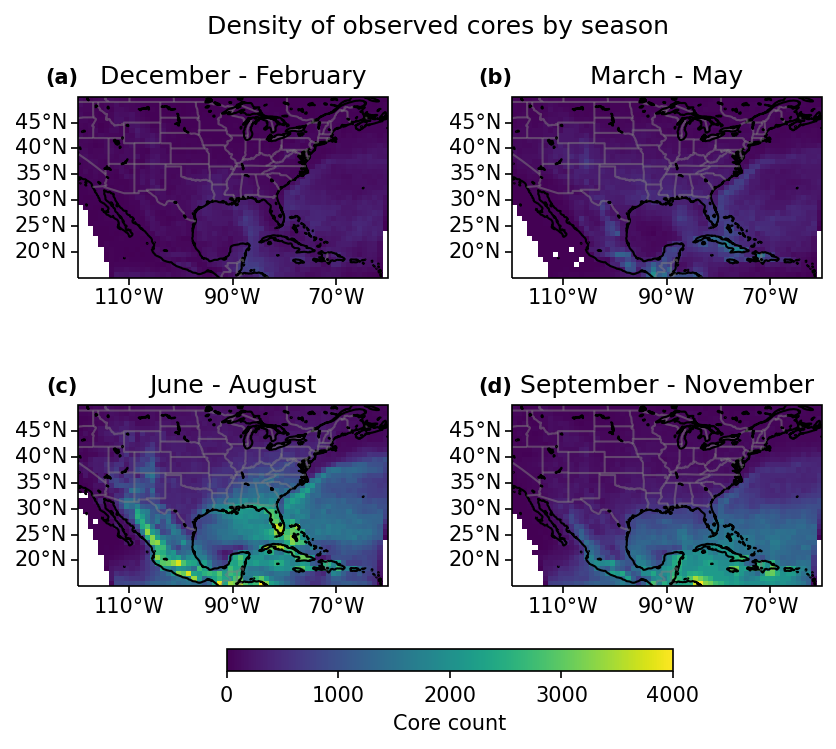

In [22]:
max_count = 4000
min_count = 0

fig, axes = plt.subplots(2, 2, dpi=dpi, figsize=(6.4,5.6), subplot_kw={"projection":ccrs.PlateCarree()})

ax1 = axes[0,0]
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax1.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax1.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax1.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

wh_djf = np.array([True if t in [1,2,12] else False for t in core_month ])
h = ax1.hist2d(np.array(core_start_lon)[np.logical_and(wh_djf, core_is_valid)], 
               np.array(core_start_lat)[np.logical_and(wh_djf, core_is_valid)], 
               bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)], 
               cmin=1, vmax=max_count, vmin=min_count)
# plt.colorbar(h[3], label="Core count")
ax1.set_title("December - February")
ax1.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=10)

ax2 = axes[0,1]
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax2.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax2.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax2.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

wh_mam = np.array([True if t in [3,4,5] else False for t in core_month ])
h = ax2.hist2d(np.array(core_start_lon)[np.logical_and(wh_mam, core_is_valid)], 
               np.array(core_start_lat)[np.logical_and(wh_mam, core_is_valid)], 
               bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)], 
               cmin=1, vmax=max_count, vmin=min_count)
# plt.colorbar(h[3], label="Core count")
ax2.set_title("March - May")
ax2.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=10)

ax3 = axes[1,0]
ax3.coastlines()
ax3.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax3.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax3.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax3.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

wh_jja = np.array([True if t in [6,7,8] else False for t in core_month ])
h = ax3.hist2d(np.array(core_start_lon)[np.logical_and(wh_jja, core_is_valid)], 
               np.array(core_start_lat)[np.logical_and(wh_jja, core_is_valid)], 
               bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)], 
               cmin=1, vmax=max_count, vmin=min_count)
# plt.colorbar(h[3], label="Core count")
ax3.set_title("June - August")
ax3.set_title("(c)", loc="left", ha="right", weight="bold", fontsize=10)

ax4 = axes[1,1]
ax4.coastlines()
ax4.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax4.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax4.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax4.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

wh_son = np.array([True if t in [9,10,11] else False for t in core_month ])
h = ax4.hist2d(np.array(core_start_lon)[np.logical_and(wh_son, core_is_valid)], 
               np.array(core_start_lat)[np.logical_and(wh_son, core_is_valid)], 
               bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)], 
               cmin=1, vmax=max_count, vmin=min_count)
# plt.colorbar(h[3], label="Core count")
ax4.set_title("September - November")
ax4.set_title("(d)", loc="left", ha="right", weight="bold", fontsize=10)

plt.suptitle("Density of observed cores by season")

fig.colorbar(h[3], ax=axes[:, :], shrink=0.6, location='bottom', label="Core count")

plt.subplots_adjust(hspace=0.3, wspace=0.4, bottom=0.3, top=0.95)

plt.draw()
add_gl_ticks(ax1, gl)
add_gl_ticks(ax2, gl)
add_gl_ticks(ax3, gl)
add_gl_ticks(ax4, gl)

figure_list.append(plt.gcf())

## Figure 4 : Proportion of cores with anvils

In [23]:
core_has_anvil = np.concatenate([np.logical_or(ds.core_has_anvil_flag.data, ds.core_anvil_removed.data) for ds in datasets])

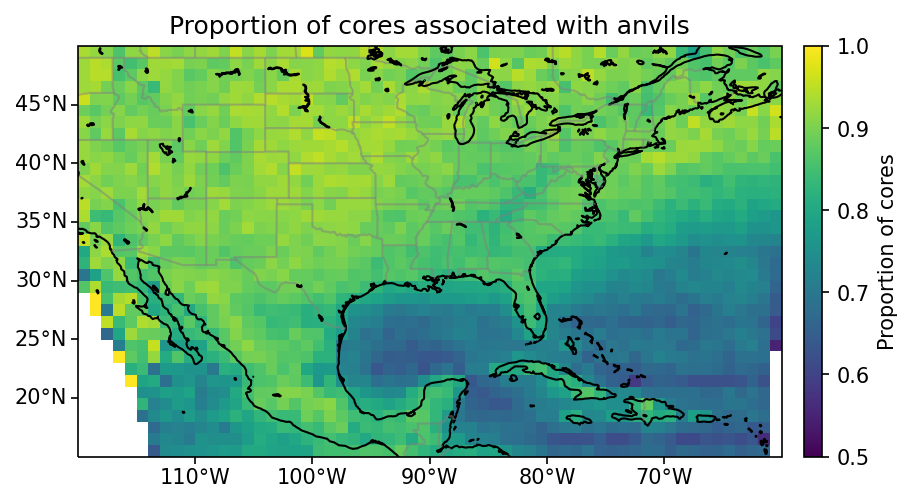

In [24]:
fig = plt.figure(dpi=dpi)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

img_data = binned_statistic_2d(
    core_start_lon[core_is_valid], core_start_lat[core_is_valid], core_has_anvil[core_is_valid], 
    bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)], 
    statistic="mean"
)
img = ax.imshow(img_data[0].T[::-1], extent=img_extent, vmax=1, vmin=0.5)

ax_divider = make_axes_locatable(ax)
cbar_size="2.5%"
cbar_pad=0.15
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="Proportion of cores")

ax.set_title("Proportion of cores associated with anvils")

plt.draw()
add_gl_ticks(ax, gl)

figure_list.append(plt.gcf())

## Figure 5: Time of detection

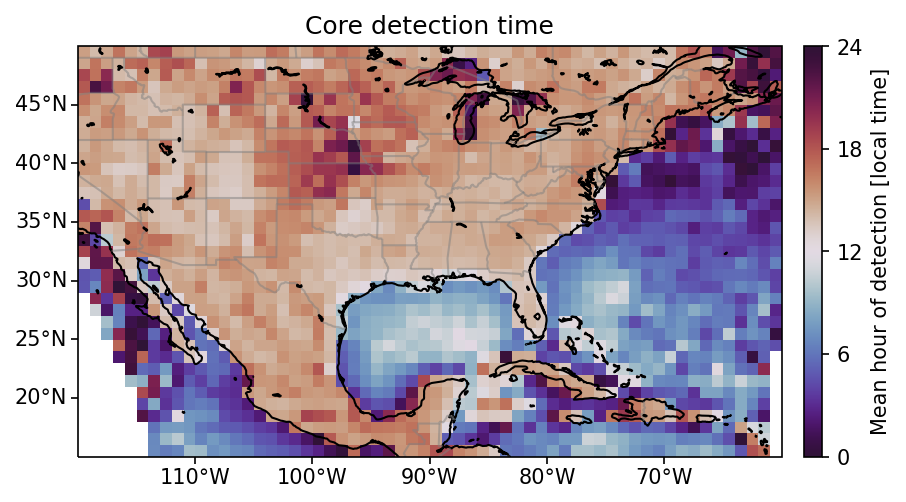

In [25]:
def circmean_hour(x):
    return circmean(x, high=24, low=0)

def circstd_hour(x):
    return circstd(x, high=24, low=0)


fig = plt.figure(dpi=dpi)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

img_data = binned_statistic_2d(
    core_start_lon[core_is_valid], core_start_lat[core_is_valid], core_local_hour[core_is_valid], 
    bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)], 
    statistic=circmean_hour
)
img = ax.imshow(img_data[0].T[::-1], extent=img_extent, vmin=0, vmax=24, cmap="twilight_shifted")

ax_divider = make_axes_locatable(ax)
cbar_size="2.5%"
cbar_pad=0.15
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="Mean hour of detection [local time]")
cbar.set_ticks([0,6,12,18,24])

ax.set_title("Core detection time")

plt.draw()
add_gl_ticks(ax, gl)

figure_list.append(plt.gcf())

In [26]:
# Find regions
# Get land/sea mask from imerg

lsm_file = "../data/lsm_data.nc"
lsm_ds = xr.open_dataset(lsm_file)

wh_sea = lsm_ds.sea_mask.sel(
    lon=slice(img_extent[0], img_extent[1]), 
    lat=slice(img_extent[2], img_extent[3])
)


In [27]:
core_sea_mask = wh_sea.T[::-1].sel(
    lon=xr.DataArray(core_start_lon, dims="points"), 
    lat=xr.DataArray(core_start_lat, dims="points"), 
method="nearest").data

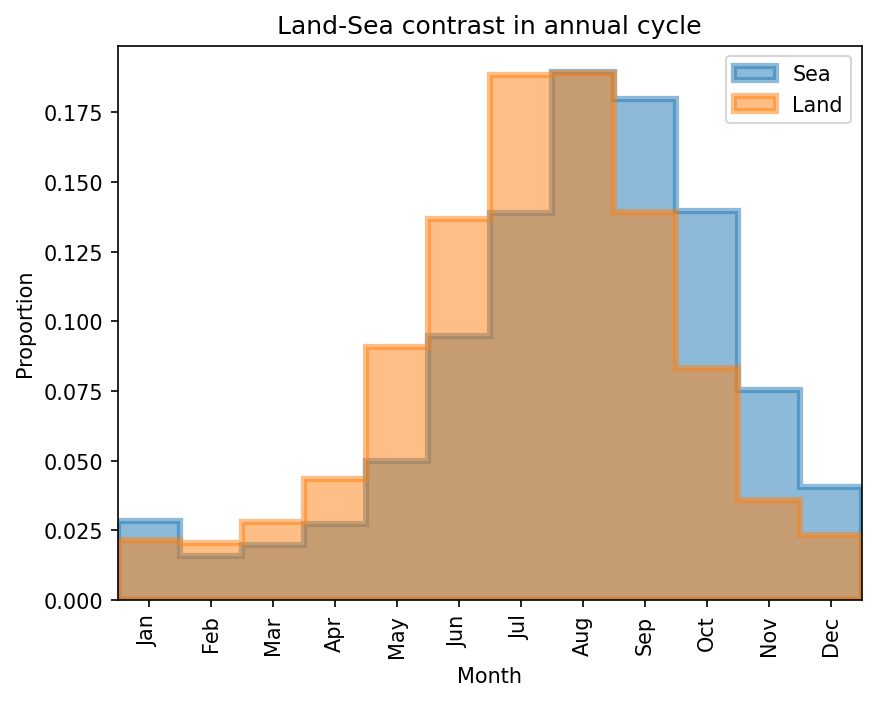

In [28]:
fig = plt.figure(dpi=dpi)
ax = plt.subplot(111)

wh_sea_valid = np.logical_and(core_is_valid, core_sea_mask)
h_sea = ax.hist(
    core_month[wh_sea_valid],
    bins=range(0,14), 
    weights=np.full((np.sum(wh_sea_valid),), 1/np.sum(wh_sea_valid)), 
    alpha=0.5, facecolor="C0", edgecolor="C0", ls='solid', lw=3, histtype='stepfilled'
)

wh_land_valid = np.logical_and(core_is_valid, ~core_sea_mask)
h_land = ax.hist(
    core_month[wh_land_valid],
    bins=range(0,14), 
    weights=np.full((np.sum(wh_land_valid),), 1/np.sum(wh_land_valid)), 
    alpha=0.5, facecolor="C1", edgecolor="C1", ls='solid', lw=3, histtype='stepfilled'
)

plt.legend(["Sea", "Land"])
ax.set_xlim([1,13])
ax.set_xticks(
    np.arange(1.5,13), 
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    rotation=90
)
ax.set_xlabel("Month")
ax.set_ylabel("Proportion")
ax.set_title("Land-Sea contrast in annual cycle")

figure_list.append(plt.gcf())

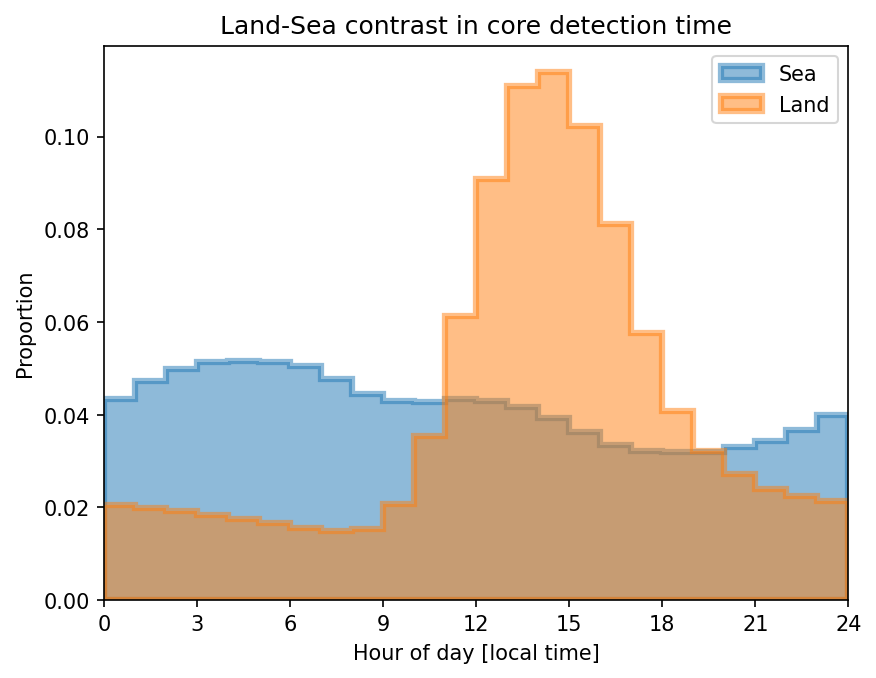

In [29]:
fig = plt.figure(dpi=dpi)
ax = plt.subplot(111)

wh_sea_valid = np.logical_and(core_is_valid, core_sea_mask)
h_sea = ax.hist(
    core_local_hour[wh_sea_valid],
    bins=range(0,25), 
    weights=np.full((np.sum(wh_sea_valid),), 1/np.sum(wh_sea_valid)), 
    alpha=0.5, facecolor="C0", edgecolor="C0", ls='solid', lw=3, histtype='stepfilled'
)

wh_land_valid = np.logical_and(core_is_valid, ~core_sea_mask)
h_land = ax.hist(
    core_local_hour[wh_land_valid],
    bins=range(0,25), 
    weights=np.full((np.sum(wh_land_valid),), 1/np.sum(wh_land_valid)), 
    alpha=0.5, facecolor="C1", edgecolor="C1", ls='solid', lw=3, histtype='stepfilled'
)

plt.legend(["Sea", "Land"])
ax.set_xlim([0,24])
ax.set_xticks(range(0,25,3))
ax.set_xlabel("Hour of day [local time]")
ax.set_ylabel("Proportion")
ax.set_title("Land-Sea contrast in core detection time")

figure_list.append(plt.gcf())

In [30]:
corrected_standard_error = lambda x:np.std(x)*len(x)**0.5/(len(x)-1)
corrected_std = lambda x:np.std(x)*(len(x)/(len(x)-1))

def binned_plot(x, y, bins, locs=None, loc_offset=0, ylog=False, color=None, statistic=None, stat_func=None, **kwargs):
    if statistic is None:
        statistic = "mean"
    if stat_func is None:
        stat_func = corrected_std
    
    if locs is None:
        locs = (bins[1:] + bins[:-1]) * 0.5 + loc_offset
    
    binned_data = binned_statistic(x, y, bins=bins, statistic=statistic)[0]
    
    if ylog:
        std = binned_statistic(x, np.log(y), bins=bins, statistic=stat_func)[0]
        std = (
            binned_data - np.exp(np.log(binned_data) - std),
            np.exp(np.log(binned_data) + std) - binned_data
        )
        counts = np.histogram(x, bins=bins)[0]
        errors = (std[0] / counts**0.5, std[1] / counts**0.5)
        
        line = plt.errorbar(locs, binned_data, std, color=color, **kwargs)
        fill = plt.fill_between(
            locs, binned_data+errors[1], binned_data-errors[0],
            alpha=0.5, color=color, edgecolor=None
        )

    else:
        std = binned_statistic(x, y, bins=bins, statistic=stat_func)[0]
        counts = np.histogram(x, bins=bins)[0]
        errors = std / counts**0.5
        
        line = plt.errorbar(locs, binned_data, std, color=color, **kwargs)
        fill = plt.fill_between(
            locs, binned_data+errors, binned_data-errors,
            alpha=0.5, color=color, edgecolor=None
        )
    
    if ylog:
        plt.yscale("log")
    
    return line, fill

In [31]:
# Onshore/offshore breeze effect
lsm_distance = ndi.distance_transform_edt(~wh_sea)*9.6
lsm_distance -= ndi.distance_transform_edt(wh_sea)*9.6
wh_coastal = xr.zeros_like(wh_sea)
wh_coastal.data = ndi.binary_opening(np.logical_and(lsm_distance<=200, ~wh_sea))

lsm_distance_ds = xr.zeros_like(wh_sea)
lsm_distance_ds.data = lsm_distance_ds.data.astype(float)
lsm_distance_ds.data = lsm_distance
core_lsm_distance = lsm_distance_ds.sel(
    lon=xr.DataArray(core_start_lon, dims="points"), 
    lat=xr.DataArray(core_start_lat, dims="points"), 
method="nearest").data

r_gulf = xr.zeros_like(wh_sea)
r_gulf.loc[-100:-81, 22.5:30] = wh_sea.loc[-100:-81, 22.5:30]

core_is_gulf = r_gulf.T[::-1].sel(
    lon=xr.DataArray(core_start_lon, dims="points"), 
    lat=xr.DataArray(core_start_lat, dims="points"), 
method="nearest").data
core_is_gulf = np.logical_and(core_is_gulf, core_is_valid)

r_gulf_coast = xr.zeros_like(wh_coastal)
r_gulf_coast.loc[-105:-80, 25:32.5] = wh_coastal.loc[-105:-80, 25:32.5]

core_is_coast = r_gulf_coast.T[::-1].sel(
    lon=xr.DataArray(core_start_lon, dims="points"), 
    lat=xr.DataArray(core_start_lat, dims="points"), 
method="nearest").data
core_is_coast = np.logical_and(core_is_coast, core_is_valid)


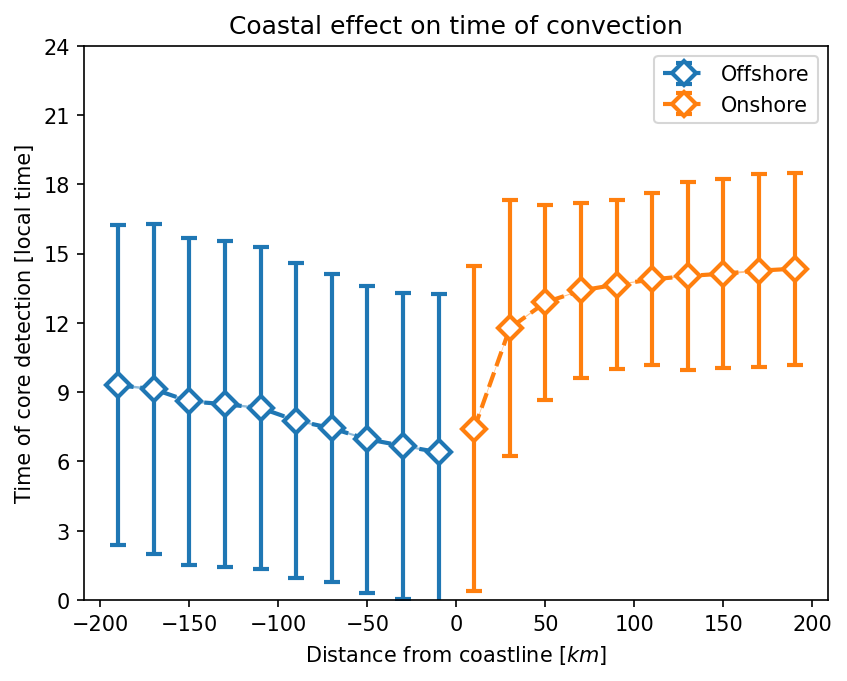

In [32]:
distance_bins = np.arange(-200,201,20)

def circmean_hour(x):
    return circmean(x, high=24, low=0)

def circstd_hour(x):
    return circstd(x, high=24, low=0)

fig = plt.figure(dpi=dpi)
ax = plt.subplot(111)

l_gulf, _ = binned_plot(
    core_lsm_distance[core_is_gulf], core_local_hour[core_is_gulf], distance_bins, statistic=circmean_hour,stat_func=circstd_hour,
    color="C0", fmt="D--", mfc="white", ms=8, capsize=4, linewidth=2, mew=2,
)

l_coast, _ = binned_plot(
    core_lsm_distance[core_is_coast], core_local_hour[core_is_coast], distance_bins, statistic=circmean_hour,stat_func=circstd_hour,
    color="C1", fmt="D--", mfc="white", ms=8, capsize=4, linewidth=2, mew=2,
)


ax.set_xlabel("Distance from coastline [$km$]")
ax.set_yticks(range(0,25,3))
ax.set_ylim([0,24])
ax.set_ylabel("Time of core detection [local time]")
ax.set_title("Coastal effect on time of convection")
plt.legend([l_gulf, l_coast], ["Offshore", "Onshore"])

figure_list.append(plt.gcf())

In [33]:
# NGP vs extra-tropical inland
# Inland regions
wh_inland = xr.zeros_like(wh_sea)
wh_inland.data = ndi.binary_opening(np.logical_and(lsm_distance>=200, ~wh_sea))
wh_inland.loc[-120:-60, 15:30] = 0

wh_NGP = xr.zeros_like(wh_sea)
wh_NGP.loc[-100:-90, 37:47] = wh_inland.loc[-100:-90, 37:47]

core_is_inland = wh_inland.T[::-1].sel(
    lon=xr.DataArray(core_start_lon, dims="points"), 
    lat=xr.DataArray(core_start_lat, dims="points"), 
method="nearest").data
core_is_inland = np.logical_and(core_is_inland, core_is_valid)

core_is_NGP = wh_NGP.T[::-1].sel(
    lon=xr.DataArray(core_start_lon, dims="points"), 
    lat=xr.DataArray(core_start_lat, dims="points"), 
method="nearest").data
core_is_NGP = np.logical_and(core_is_NGP, core_is_valid)


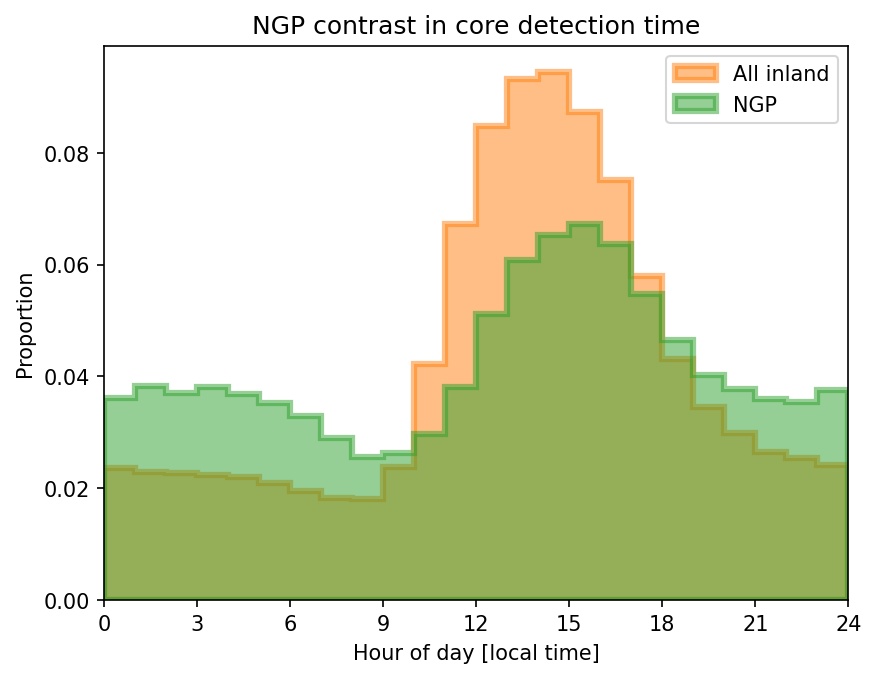

In [34]:
fig = plt.figure(dpi=dpi)
ax = plt.subplot(111)

h_sea = ax.hist(
    core_local_hour[core_is_inland],
    bins=range(0,25), 
    weights=np.full((np.sum(core_is_inland),), 1/np.sum(core_is_inland)), 
    alpha=0.5, facecolor="C1", edgecolor="C1", ls='solid', lw=3, histtype='stepfilled'
)

h_land = ax.hist(
    core_local_hour[core_is_NGP],
    bins=range(0,25), 
    weights=np.full((np.sum(core_is_NGP),), 1/np.sum(core_is_NGP)), 
    alpha=0.5, facecolor="C2", edgecolor="C2", ls='solid', lw=3, histtype='stepfilled'
)

plt.legend(["All inland", "NGP"])
ax.set_xlim([0,24])
ax.set_xticks(range(0,25,3))
ax.set_xlabel("Hour of day [local time]")
ax.set_ylabel("Proportion")
ax.set_title("NGP contrast in core detection time")

figure_list.append(plt.gcf())

## Figure 6 : Core propagation

In [35]:
core_azimuths = np.concatenate([ds.core_propagation_direction for ds in datasets])
core_speed = np.concatenate([ds.core_propagation_speed for ds in datasets])

In [36]:
def block_reduce_quiver(x, y, u, v, *args, ax=None, spacing=1, block_method="slice", **kwargs):
    if ax is None:
        ax = plt.gca()
    if block_method == "slice":
        slc = slice(spacing // 2, None, spacing)
        quiv = ax.quiver(
            x[slc],
            y[slc],
            u[slc, slc],
            v[slc, slc],
            *args,
            **kwargs,
        )
    elif block_method == "reduce":
        from skimage.measure import block_reduce
        new_x, new_y = block_reduce(x, (spacing,), np.nanmean), block_reduce(y, (spacing,), np.nanmean)
        new_u, new_v = block_reduce(u, (spacing, spacing), np.nanmean), block_reduce(v, (spacing, spacing), np.nanmean)
        quiv = ax.quiver(new_x, new_y, new_u, new_v, *args, **kwargs)
    else:
        raise ValueError("invalid input for 'block_method'")
    return quiv

/Users/jonesw/mambaforge-pypy3/envs/thesis_notebooks/lib/python3.11/site-packages/skimage/measure/block.py:89: RuntimeWarning: Mean of empty slice
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),


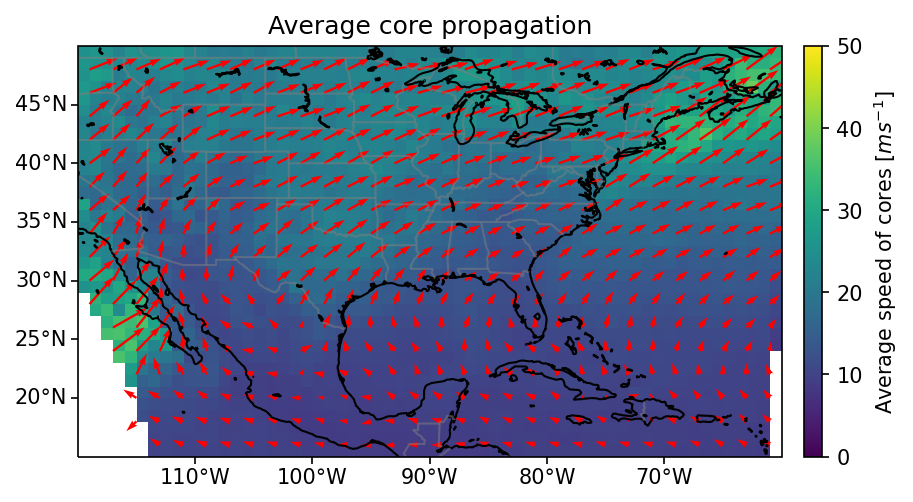

In [37]:
def circmean_degrees(x):
    return circmean(x, high=180, low=-180)

fig = plt.figure(dpi=dpi)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

img_data = binned_statistic_2d(
    core_start_lon[core_is_valid], core_start_lat[core_is_valid], core_speed[core_is_valid], 
    bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)], 
    statistic="mean"
)
img = ax.imshow(img_data[0].T[::-1], extent=img_extent, vmin=0, vmax=50)

core_avg_speed = binned_statistic_2d(
    core_start_lon[core_is_valid], core_start_lat[core_is_valid], core_speed[core_is_valid], 
    bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)], 
    statistic="mean"
)[0]
core_avg_angle = binned_statistic_2d(
    core_start_lon[core_is_valid], core_start_lat[core_is_valid], core_azimuths[core_is_valid], 
    bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)], 
    statistic=circmean_degrees
)[0]
block_reduce_quiver(
    (np.arange(img_extent[0],img_extent[1])+0.5), 
    (np.arange(img_extent[2],img_extent[3])+0.5)[:-1],
    (np.sin(np.deg2rad(core_avg_angle)) * core_avg_speed).T[:-1],
    (np.cos(np.deg2rad(core_avg_angle)) * core_avg_speed).T[:-1],
    spacing=2,
    block_method="reduce",
    color="r",
    scale=1e1, 
    width=0.2,
    scale_units="xy",
    units="xy"
)

ax_divider = make_axes_locatable(ax)
cbar_size="2.5%"
cbar_pad=0.15
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="Average speed of cores [$ms^{-1}$]")

ax.set_title("Average core propagation")

plt.draw()
add_gl_ticks(ax, gl)

figure_list.append(plt.gcf())

## Figure 7 : Average core lifetime

In [38]:
core_BT_max = np.concatenate([
    ds.core_BT_max.values for ds in datasets
])
core_start_BT = np.concatenate([ds.core_step_BT_mean.loc[ds.core_initial_core_step_index] for ds in datasets])
core_warm_start = np.logical_and(core_is_valid, core_start_BT >= 273)

In [39]:
core_warm_start.sum(), core_warm_start.size

(529873, 3877130)

In [40]:
core_lifetime = np.concatenate([ds.core_lifetime.data for ds in datasets])
core_lifetime_minutes = core_lifetime.astype(int)/6e10
core_lifetime_seconds = core_lifetime.astype(int)/1e9

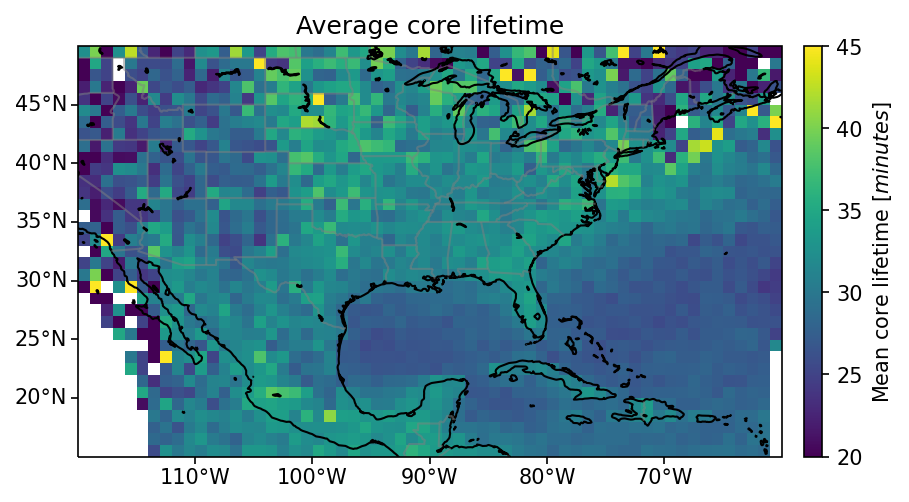

In [41]:
fig = plt.figure(dpi=dpi)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

img_data = binned_statistic_2d(
    core_start_lon[core_warm_start], core_start_lat[core_warm_start], core_lifetime_minutes[core_warm_start], 
    bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)], 
    statistic="mean"
)
img = ax.imshow(img_data[0].T[::-1], extent=img_extent, vmin=20, vmax=45)

ax_divider = make_axes_locatable(ax)
cbar_size="2.5%"
cbar_pad=0.15
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="Mean core lifetime [$minutes$]")

ax.set_title("Average core lifetime")

plt.draw()
add_gl_ticks(ax, gl)

figure_list.append(plt.gcf())

## Figure 8 : Average core maximum cooling rate

In [42]:
core_cooling_rate = np.concatenate([ds.core_cooling_rate.data for ds in datasets])

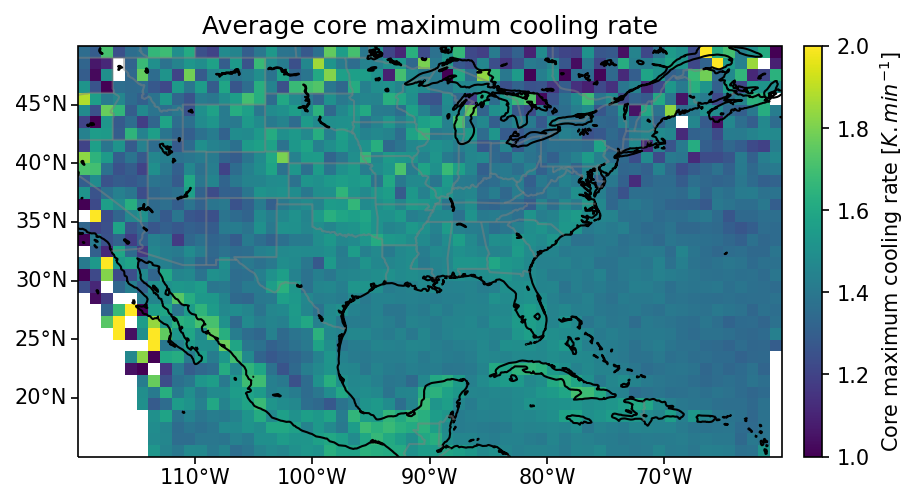

In [43]:
fig = plt.figure(dpi=dpi)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

img_data = binned_statistic_2d(
    core_start_lon[core_warm_start], core_start_lat[core_warm_start], core_cooling_rate[core_warm_start], 
    bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)], 
    statistic=np.nanmean
)
img = ax.imshow(img_data[0].T[::-1], extent=img_extent, vmin=1.0, vmax=2.0)

ax_divider = make_axes_locatable(ax)
cbar_size="2.5%"
cbar_pad=0.15
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="Core maximum cooling rate [$K.min^{-1}$]")
# cbar.set_ticks([0.75,1.0,1.25,1.5,1.75])

ax.set_title("Average core maximum cooling rate")

plt.draw()
add_gl_ticks(ax, gl)

figure_list.append(plt.gcf())

## Figure 9 : Core lifetime and maximum cooling rate distributions

In [44]:
core_max_area = np.concatenate(
    [ds.core_max_area for ds in datasets]
)
core_BT_min = np.concatenate([
    ds.core_BT_min.values for ds in datasets
])

In [45]:
is_initial_core = np.concatenate([np.isin(ds.core.data, ds.anvil_initial_core_index.data[ds.thin_anvil_is_valid]) for ds in datasets])

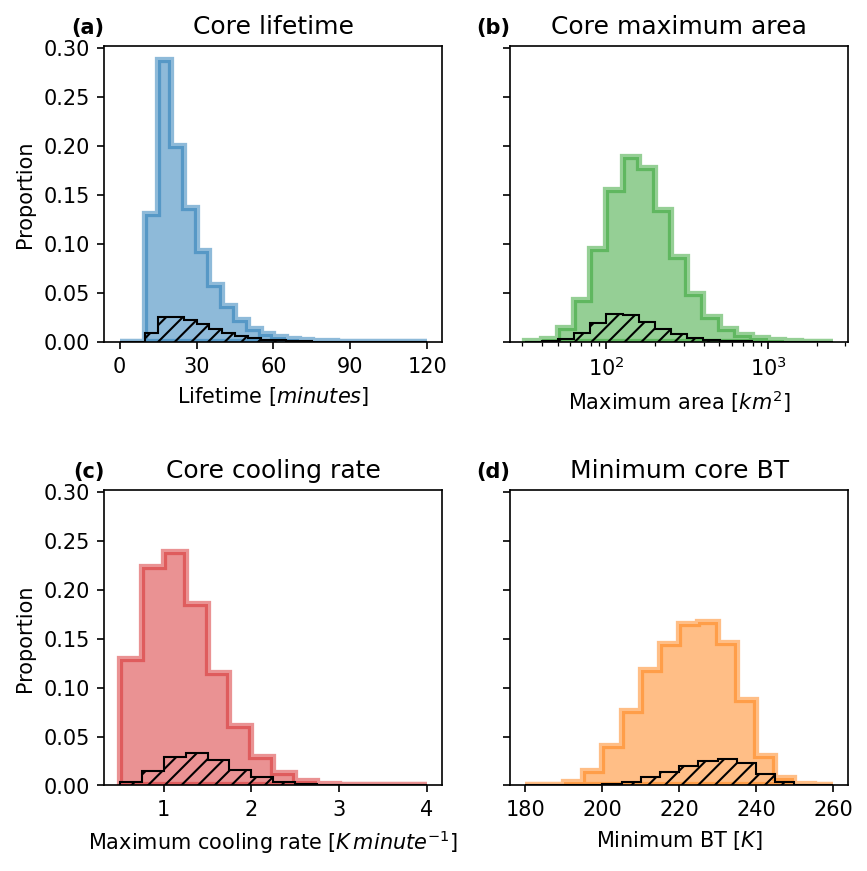

In [46]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, dpi=dpi, sharey=True, figsize=(6.4,6.4))

core_lifetime_bins = np.arange(0,125,5)
ax1.hist(
    core_lifetime_minutes[core_is_valid], bins=core_lifetime_bins, 
    weights=np.full((np.sum(core_is_valid),), 1/np.sum(core_is_valid)), 
    alpha=0.5, facecolor="C0", edgecolor="C0", ls='solid', lw=3, histtype='stepfilled'
)

ax1.hist(
    core_lifetime_minutes[core_warm_start], bins=core_lifetime_bins, 
    weights=np.full((np.sum(core_warm_start),), 1/np.sum(core_is_valid)), 
    histtype='step', linewidth=1, facecolor='none', 
    hatch='///', edgecolor='k', fill=True
)

ax1.set_xticks(range(0,125,30))
ax1.set_xlabel("Lifetime [$minutes$]")
ax1.set_ylabel("Proportion")
ax1.set_title("Core lifetime")
ax1.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=10)

core_area_bins = 10**np.arange(1.5,3.5,0.1)
ax2.hist(
    core_max_area[core_is_valid], bins=core_area_bins, 
    weights=np.full((np.sum(core_is_valid),), 1/np.sum(core_is_valid)), 
    alpha=0.5, facecolor="C2", edgecolor="C2", ls='solid', lw=3, histtype='stepfilled'
)
ax2.hist(
    core_max_area[core_warm_start], bins=core_area_bins, 
    weights=np.full((np.sum(core_warm_start),), 1/np.sum(core_is_valid)), 
    histtype='step', linewidth=1, facecolor='none', 
    hatch='///', edgecolor='k', fill=True
)

ax2.set_xscale("log")
ax2.set_xlabel("Maximum area [$km^2$]")
ax2.set_title("Core maximum area")
ax2.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=10)

cooling_rate_bins = np.arange(0.5,4.1,0.25)
ax3.hist(
    core_cooling_rate[core_is_valid], bins=cooling_rate_bins, 
    weights=np.full((np.sum(core_is_valid),), 1/np.sum(core_is_valid)),   
    alpha=0.5, facecolor="C3", edgecolor="C3", ls='solid', lw=3, histtype='stepfilled'
)
ax3.hist(
    core_cooling_rate[core_warm_start], bins=cooling_rate_bins, 
    weights=np.full((np.sum(core_warm_start),), 1/np.sum(core_is_valid)), 
    histtype='step', linewidth=1, facecolor='none', 
    hatch='///', edgecolor='k', fill=True
)

ax3.set_xlabel("Maximum cooling rate [$K\,minute^{-1}$]")
ax3.set_title("Core cooling rate")
ax3.set_ylabel("Proportion")
ax3.set_title("(c)", loc="left", ha="right", weight="bold", fontsize=10)

core_BT_bins = np.arange(180,261,5)
ax4.hist(
    core_BT_min[core_is_valid], bins=core_BT_bins, 
    weights=np.full((np.sum(core_is_valid),), 1/np.sum(core_is_valid)),   
    alpha=0.5, facecolor="C1", edgecolor="C1", ls='solid', lw=3, histtype='stepfilled'
)
ax4.hist(
    core_BT_min[core_warm_start], bins=core_BT_bins, 
    weights=np.full((np.sum(core_warm_start),), 1/np.sum(core_is_valid)), 
    histtype='step', linewidth=1, facecolor='none', 
    hatch='///', edgecolor='k', fill=True
)

ax4.set_xlabel("Minimum BT [$K$]")
ax4.set_title("Minimum core BT")
ax4.set_title("(d)", loc="left", ha="right", weight="bold", fontsize=10)

plt.subplots_adjust(hspace=0.5)

figure_list.append(plt.gcf())

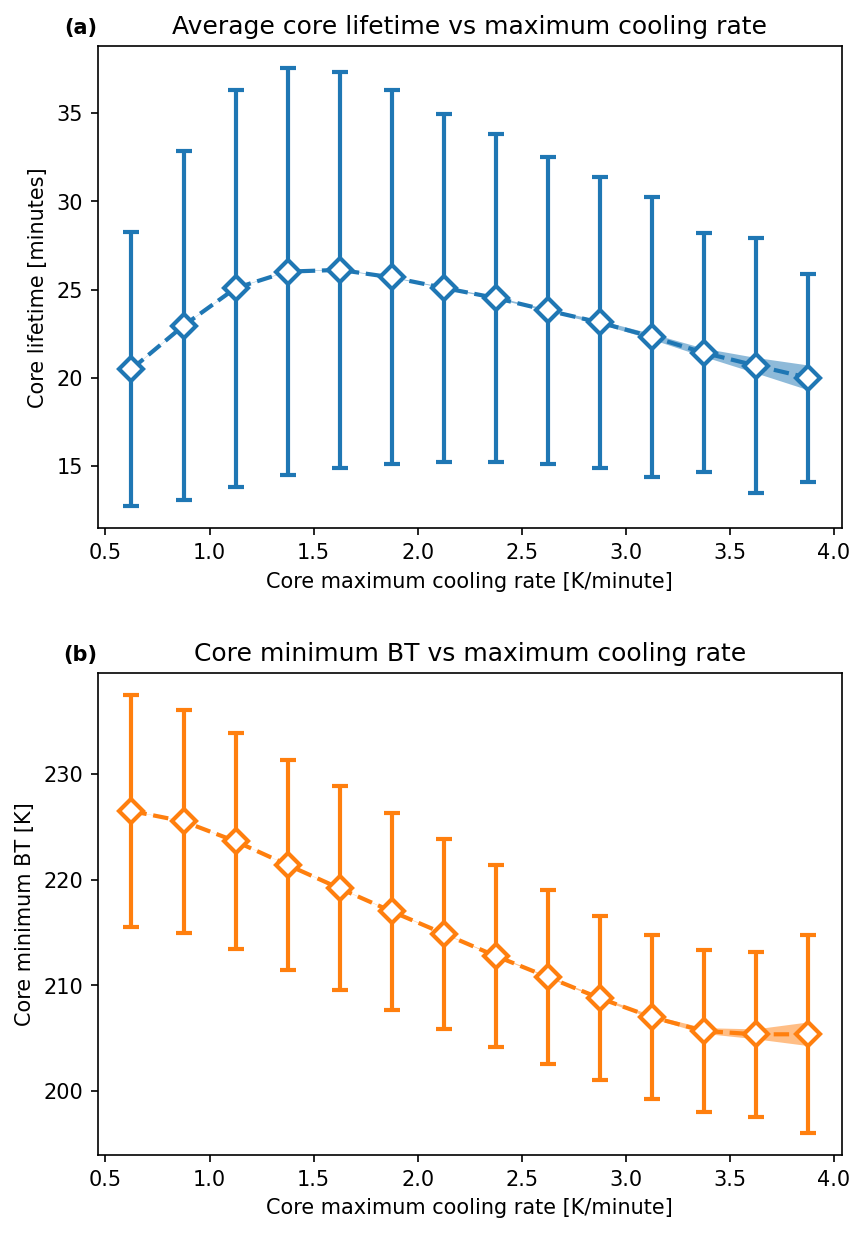

In [47]:
fig = plt.figure(dpi=dpi, figsize=(6.4,9.6))

ax = plt.subplot(211)

binned_plot(
    core_cooling_rate[core_is_valid], core_lifetime_minutes[core_is_valid], cooling_rate_bins,
    color="C0", fmt="D--", mfc="white", ms=8, capsize=4, linewidth=2, mew=2,
)

plt.xlabel("Core maximum cooling rate [K/minute]")
plt.ylabel("Core lifetime [minutes]")
plt.title("Average core lifetime vs maximum cooling rate")
ax.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=10)

ax = plt.subplot(212)
binned_plot(
    core_cooling_rate[core_is_valid], core_BT_min[core_is_valid], cooling_rate_bins,
    color="C1", fmt="D--", mfc="white", ms=8, capsize=4, linewidth=2, mew=2
)

plt.xlabel("Core maximum cooling rate [K/minute]")
plt.ylabel("Core minimum BT [K]")
plt.title("Core minimum BT vs maximum cooling rate")
ax.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=10)

plt.subplots_adjust(hspace=0.3)

figure_list.append(plt.gcf())

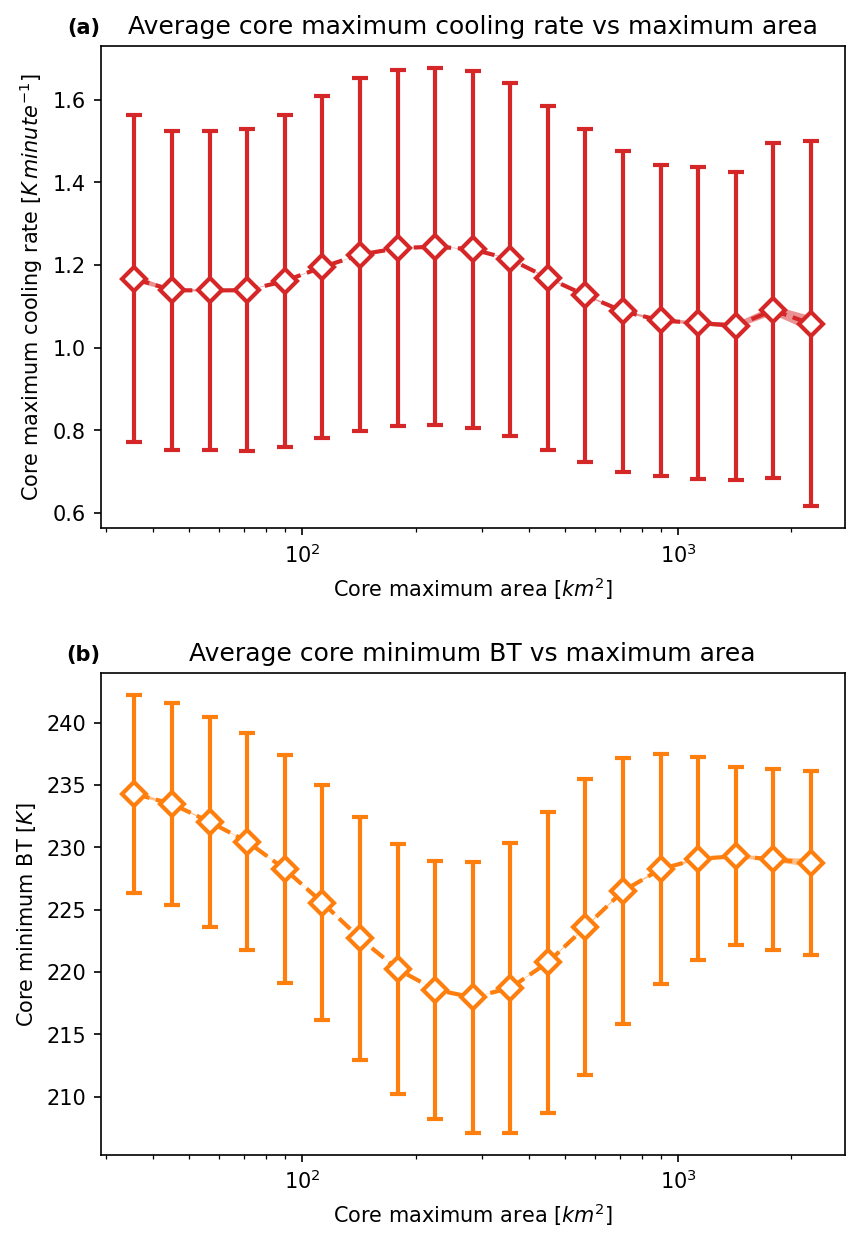

In [48]:
fig = plt.figure(dpi=dpi, figsize=(6.4,9.6))

ax = plt.subplot(211)

binned_plot(
    core_max_area[core_is_valid], core_cooling_rate[core_is_valid], core_area_bins,
    color="C3", fmt="D--", mfc="white", ms=8, capsize=4, linewidth=2, mew=2,
)
plt.xscale("log")

plt.ylabel("Core maximum cooling rate [$K\,minute^{-1}$]")
plt.xlabel("Core maximum area [$km^2$]")
plt.title("Average core maximum cooling rate vs maximum area")
ax.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=10)

ax = plt.subplot(212)
binned_plot(
    core_max_area[core_is_valid], core_BT_min[core_is_valid], core_area_bins,
    color="C1", fmt="D--", mfc="white", ms=8, capsize=4, linewidth=2, mew=2
)
plt.xscale("log")

plt.ylabel("Core minimum BT [$K$]")
plt.xlabel("Core maximum area [$km^2$]")
plt.title("Average core minimum BT vs maximum area")
ax.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=10)

plt.subplots_adjust(hspace=0.3)

figure_list.append(plt.gcf())

## Figure 10 : Observed anvils by season

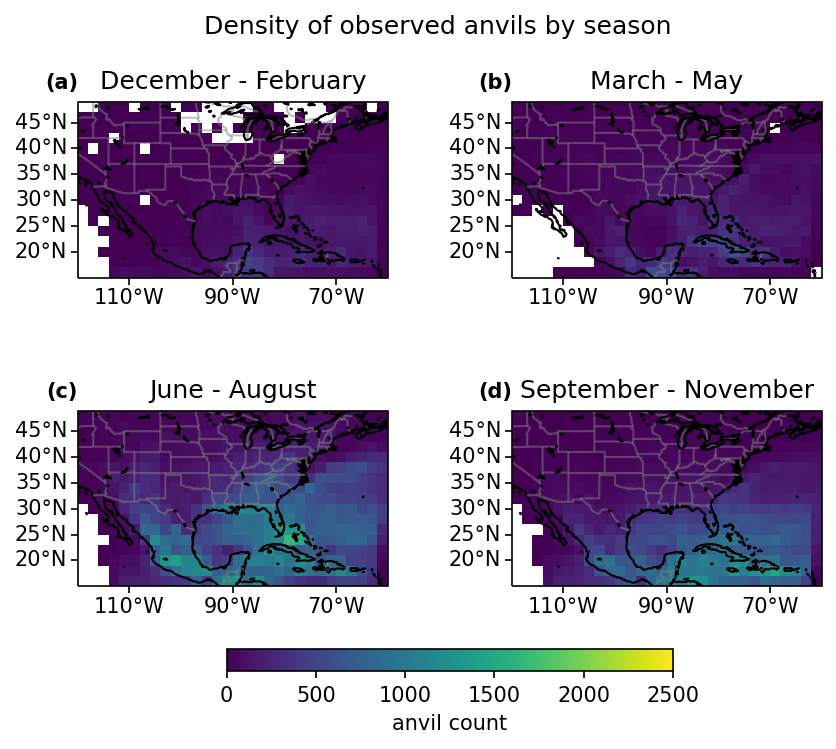

In [49]:
max_count = 2500
min_count = 0

fig, axes = plt.subplots(2, 2, dpi=dpi, figsize=(6.4,5.6), subplot_kw={"projection":ccrs.PlateCarree()})

anvil_bins = [
    np.arange(img_extent[0], img_extent[1]+1, 2), 
    np.arange(img_extent[2], img_extent[3]+1, 2)
]

ax1 = axes[0,0]
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax1.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax1.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax1.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

wh_djf = np.array([True if t in [1,2,12] else False for t in anvil_month ])
h = ax1.hist2d(np.array(anvil_start_lon)[np.logical_and(wh_djf, anvil_is_valid)], 
               np.array(anvil_start_lat)[np.logical_and(wh_djf, anvil_is_valid)], 
               bins=anvil_bins, cmin=1, vmax=max_count, vmin=min_count)
# plt.colorbar(h[3], label="anvil count")
ax1.set_title("December - February")
ax1.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=10)

ax2 = axes[0,1]
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax2.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax2.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax2.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

wh_mam = np.array([True if t in [3,4,5] else False for t in anvil_month ])
h = ax2.hist2d(np.array(anvil_start_lon)[np.logical_and(wh_mam, anvil_is_valid)], 
               np.array(anvil_start_lat)[np.logical_and(wh_mam, anvil_is_valid)], 
               bins=anvil_bins, cmin=1, vmax=max_count, vmin=min_count)
# plt.colorbar(h[3], label="anvil count")
ax2.set_title("March - May")
ax2.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=10)

ax3 = axes[1,0]
ax3.coastlines()
ax3.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax3.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax3.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax3.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

wh_jja = np.array([True if t in [6,7,8] else False for t in anvil_month ])
h = ax3.hist2d(np.array(anvil_start_lon)[np.logical_and(wh_jja, anvil_is_valid)], 
               np.array(anvil_start_lat)[np.logical_and(wh_jja, anvil_is_valid)], 
               bins=anvil_bins, cmin=1, vmax=max_count, vmin=min_count)
# plt.colorbar(h[3], label="anvil count")
ax3.set_title("June - August")
ax3.set_title("(c)", loc="left", ha="right", weight="bold", fontsize=10)

ax4 = axes[1,1]
ax4.coastlines()
ax4.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax4.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax4.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax4.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

wh_son = np.array([True if t in [9,10,11] else False for t in anvil_month ])
h = ax4.hist2d(np.array(anvil_start_lon)[np.logical_and(wh_son, anvil_is_valid)], 
               np.array(anvil_start_lat)[np.logical_and(wh_son, anvil_is_valid)], 
               bins=anvil_bins, cmin=1, vmax=max_count, vmin=min_count)
# plt.colorbar(h[3], label="anvil count")
ax4.set_title("September - November")
ax4.set_title("(d)", loc="left", ha="right", weight="bold", fontsize=10)

plt.suptitle("Density of observed anvils by season")

fig.colorbar(h[3], ax=axes[:, :], shrink=0.6, location='bottom', label="anvil count")

plt.subplots_adjust(hspace=0.3, wspace=0.4, bottom=0.3, top=0.95)

plt.draw()
add_gl_ticks(ax1, gl)
add_gl_ticks(ax2, gl)
add_gl_ticks(ax3, gl)
add_gl_ticks(ax4, gl)

figure_list.append(plt.gcf())

## Figure 11: Average number of cores

In [50]:
anvil_core_count = np.concatenate([ds.anvil_core_count.data for ds in datasets])

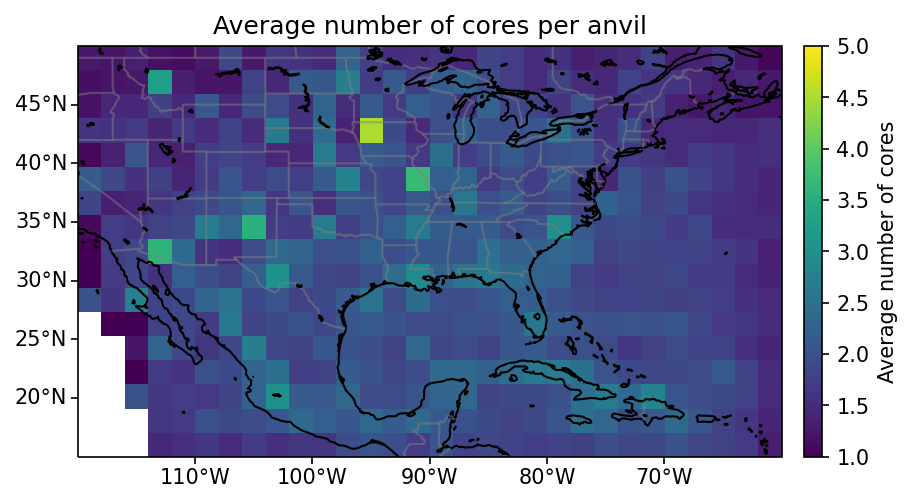

In [51]:
fig = plt.figure(dpi=dpi)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

from scipy.stats import binned_statistic_2d, circmean

img_data = binned_statistic_2d(
    anvil_start_lon[anvil_is_valid], anvil_start_lat[anvil_is_valid], anvil_core_count[anvil_is_valid], 
    bins=[np.arange(img_extent[0],img_extent[1]+1,2), 
          np.arange(img_extent[2],img_extent[3]+1,2)], 
    statistic="mean"
)
img = ax.imshow(img_data[0].T[::-1], extent=img_extent, vmin=1, vmax=5)

ax_divider = make_axes_locatable(ax)
cbar_size="2.5%"
cbar_pad=0.15
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="Average number of cores")

ax.set_title("Average number of cores per anvil")

plt.draw()
add_gl_ticks(ax, gl)

figure_list.append(plt.gcf())

## Figure 12 : Average anvil lifetime

In [52]:
anvil_lifetime = np.concatenate([ds.thick_anvil_lifetime for ds in datasets])
anvil_lifetime_hours = anvil_lifetime.astype(int)/3.6e12

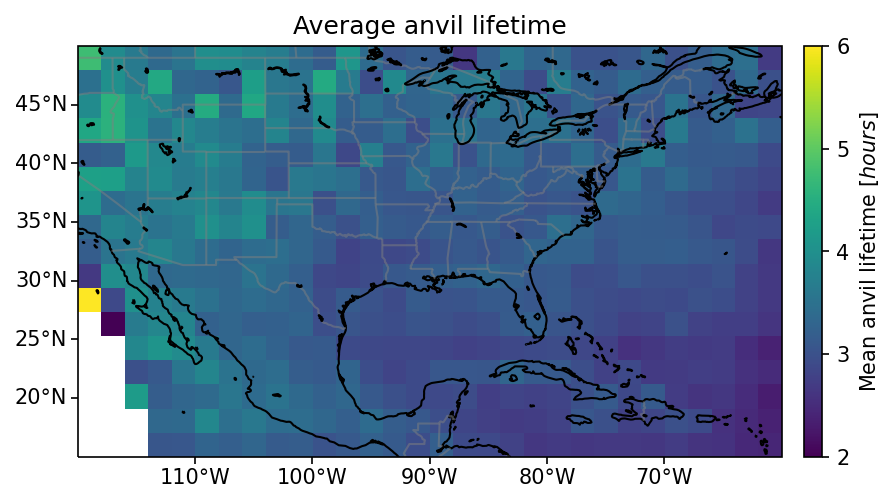

In [53]:
fig = plt.figure(dpi=dpi)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

from scipy.stats import binned_statistic_2d, circmean

img_data = binned_statistic_2d(
    anvil_start_lon[anvil_is_valid], anvil_start_lat[anvil_is_valid], anvil_lifetime_hours[anvil_is_valid],
    bins=[
        np.arange(img_extent[0], img_extent[1]+1, 2), 
        np.arange(img_extent[2], img_extent[3]+1, 2)
    ], 
    statistic="mean"
)
img = ax.imshow(img_data[0].T[::-1], extent=img_extent, vmin=2, vmax=6)

ax_divider = make_axes_locatable(ax)
cbar_size="2.5%"
cbar_pad=0.15
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="Mean anvil lifetime [$hours$]")
cbar.set_ticks([2,3,4,5,6])

ax.set_title("Average anvil lifetime")

plt.draw()
add_gl_ticks(ax, gl)

figure_list.append(plt.gcf())

## Figure 13 : Anvil propagation

In [54]:
anvil_azimuths = np.concatenate([ds.anvil_propagation_direction for ds in datasets])
anvil_speed = np.concatenate([ds.anvil_propagation_speed for ds in datasets])

/Users/jonesw/mambaforge-pypy3/envs/thesis_notebooks/lib/python3.11/site-packages/skimage/measure/block.py:89: RuntimeWarning: Mean of empty slice
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),


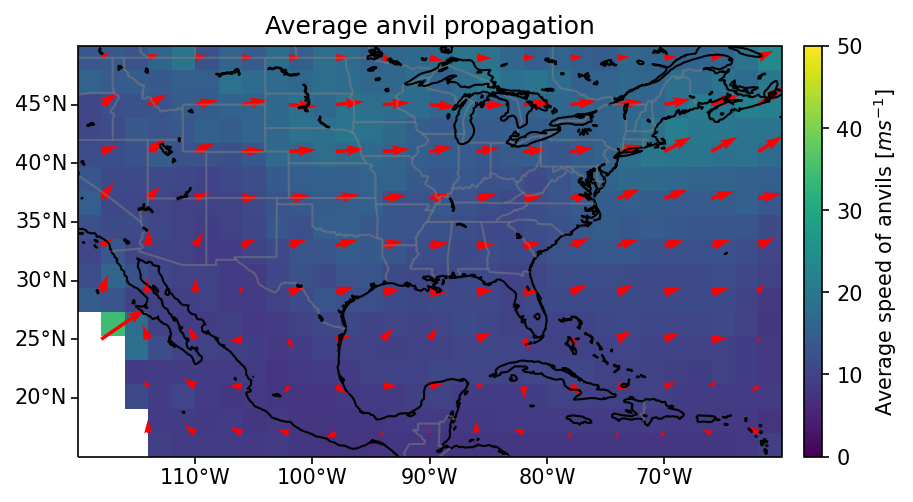

In [55]:
def circmean_degrees(x):
    return circmean(x, high=180, low=-180)

fig = plt.figure(dpi=dpi)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

anvil_avg_speed = binned_statistic_2d(
    anvil_start_lon[anvil_is_valid], anvil_start_lat[anvil_is_valid], anvil_speed[anvil_is_valid], 
    bins=[
        np.arange(img_extent[0], img_extent[1]+1 ,2), 
        np.arange(img_extent[2], img_extent[3]+1 ,2)
    ], 
    statistic="mean"
)[0]
img = ax.imshow(anvil_avg_speed.T[::-1], extent=img_extent, vmin=0, vmax=50)


anvil_avg_angle = binned_statistic_2d(
    anvil_start_lon[anvil_is_valid], anvil_start_lat[anvil_is_valid], anvil_azimuths[anvil_is_valid], 
    bins=[
        np.arange(img_extent[0], img_extent[1]+1, 2), 
        np.arange(img_extent[2], img_extent[3]+1, 2)
    ], 
    statistic=circmean_degrees
)[0]
block_reduce_quiver(
    (np.arange(img_extent[0], img_extent[1], 2) + 1), 
    (np.arange(img_extent[2], img_extent[3], 2) + 1),
    (np.sin(np.deg2rad(anvil_avg_angle)) * anvil_avg_speed).T,
    (np.cos(np.deg2rad(anvil_avg_angle)) * anvil_avg_speed).T,
    spacing=2,
    block_method="reduce",
    color="r",
    scale=7.5, 
    width=0.3,
    scale_units="xy",
    units="xy"
)

ax_divider = make_axes_locatable(ax)
cbar_size="2.5%"
cbar_pad=0.15
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="Average speed of anvils [$ms^{-1}$]")

ax.set_title("Average anvil propagation")

plt.draw()
add_gl_ticks(ax, gl)

figure_list.append(plt.gcf())

## Figure 14 : Anvil time of detection

In [56]:
anvil_local_time = anvil_start_t + np.array(anvil_start_lon/15*3600, "timedelta64[s]")
anvil_local_hour = (anvil_local_time - anvil_local_time.astype("datetime64[D]")).astype(int)/3.6e12

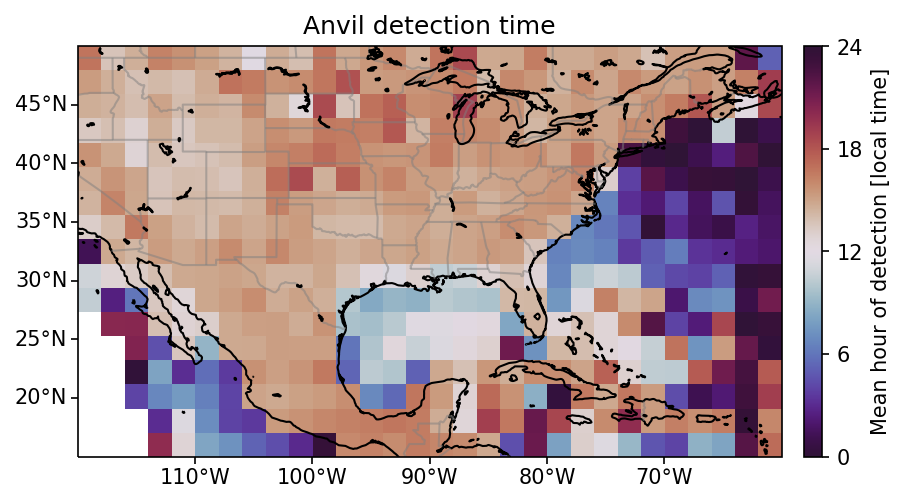

In [57]:
def circmean_hour(x):
    return circmean(x, high=24, low=0)

def circstd_hour(x):
    return circstd(x, high=24, low=0)


fig = plt.figure(dpi=dpi)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

img_data = binned_statistic_2d(
    anvil_start_lon[anvil_is_valid], anvil_start_lat[anvil_is_valid], anvil_local_hour[anvil_is_valid], 
    bins=[
        np.arange(img_extent[0], img_extent[1]+1, 2), 
        np.arange(img_extent[2], img_extent[3]+1, 2)], 
    statistic=circmean_hour
)
img = ax.imshow(img_data[0].T[::-1], extent=img_extent, vmin=0, vmax=24, cmap="twilight_shifted")

ax_divider = make_axes_locatable(ax)
cbar_size="2.5%"
cbar_pad=0.15
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="Mean hour of detection [local time]")
cbar.set_ticks([0,6,12,18,24])

ax.set_title("Anvil detection time")

plt.draw()
add_gl_ticks(ax, gl)

figure_list.append(plt.gcf())

## Figure 15: Anvil maximum area

In [58]:
anvil_max_area = np.concatenate([ds.thick_anvil_max_area for ds in datasets])


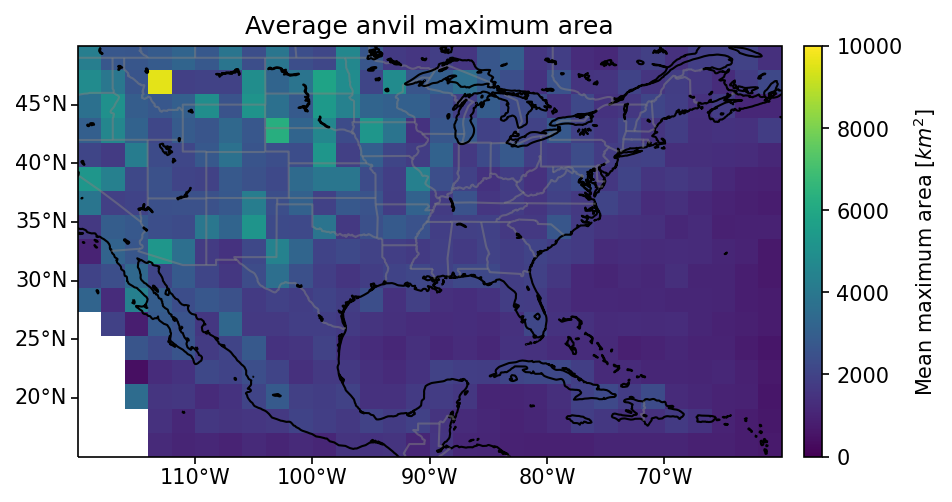

In [59]:
fig = plt.figure(dpi=dpi)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

img_data = binned_statistic_2d(
    anvil_start_lon[anvil_is_valid], anvil_start_lat[anvil_is_valid], anvil_max_area[anvil_is_valid],
    bins=[
        np.arange(img_extent[0], img_extent[1]+1, 2), 
        np.arange(img_extent[2], img_extent[3]+1, 2)
    ], 
    statistic="mean"
)
img = ax.imshow(img_data[0].T[::-1], extent=img_extent, vmin=0, vmax=10000)

ax_divider = make_axes_locatable(ax)
cbar_size="2.5%"
cbar_pad=0.15
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="Mean maximum area [$km^2$]")

ax.set_title("Average anvil maximum area")

plt.draw()
add_gl_ticks(ax, gl)

figure_list.append(plt.gcf())

In [60]:
anvil_number_of_cores = np.concatenate([ds.anvil_core_count.data for ds in datasets])

anvil_max_area = np.concatenate([ds.thick_anvil_max_area.data for ds in datasets])
thin_anvil_max_area = np.concatenate([ds.thin_anvil_max_area.data for ds in datasets])

anvil_lifetime = np.concatenate([ds.thick_anvil_lifetime.data for ds in datasets]).astype("timedelta64[s]").astype(int)/3600

anvil_total_area = np.concatenate([ds.thick_anvil_total_area.data for ds in datasets])
thin_anvil_total_area = np.concatenate([ds.thin_anvil_total_area.data for ds in datasets])

anvil_ctt_mean = np.concatenate([ds.thick_anvil_BT_mean.data for ds in datasets])
anvil_ctt_min = np.concatenate([ds.thick_anvil_BT_min.data for ds in datasets])

initial_core_cooling_rate = np.concatenate([ds.core_cooling_rate.loc[ds.anvil_initial_core_index].data for ds in datasets])


In [61]:
anvil_has_multiple_cores = np.logical_and(anvil_is_valid, anvil_number_of_cores > 1)

In [62]:
def anvil_initiation_t(ds):
    return np.minimum(
        ds.core_start_t.loc[ds.anvil_initial_core_index.data].data, 
        ds.thick_anvil_start_t.data
    )

anvil_time_to_min_BT = np.concatenate([ds.thick_anvil_min_BT_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
anvil_time_to_max_thick_area = np.concatenate([ds.thick_anvil_max_area_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
anvil_time_to_max_thin_area = np.concatenate([ds.thin_anvil_max_area_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
thick_anvil_lifetime = np.concatenate([ds.thick_anvil_end_t.data - anvil_initiation_t(ds)for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
thin_anvil_lifetime = np.concatenate([ds.thin_anvil_end_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600


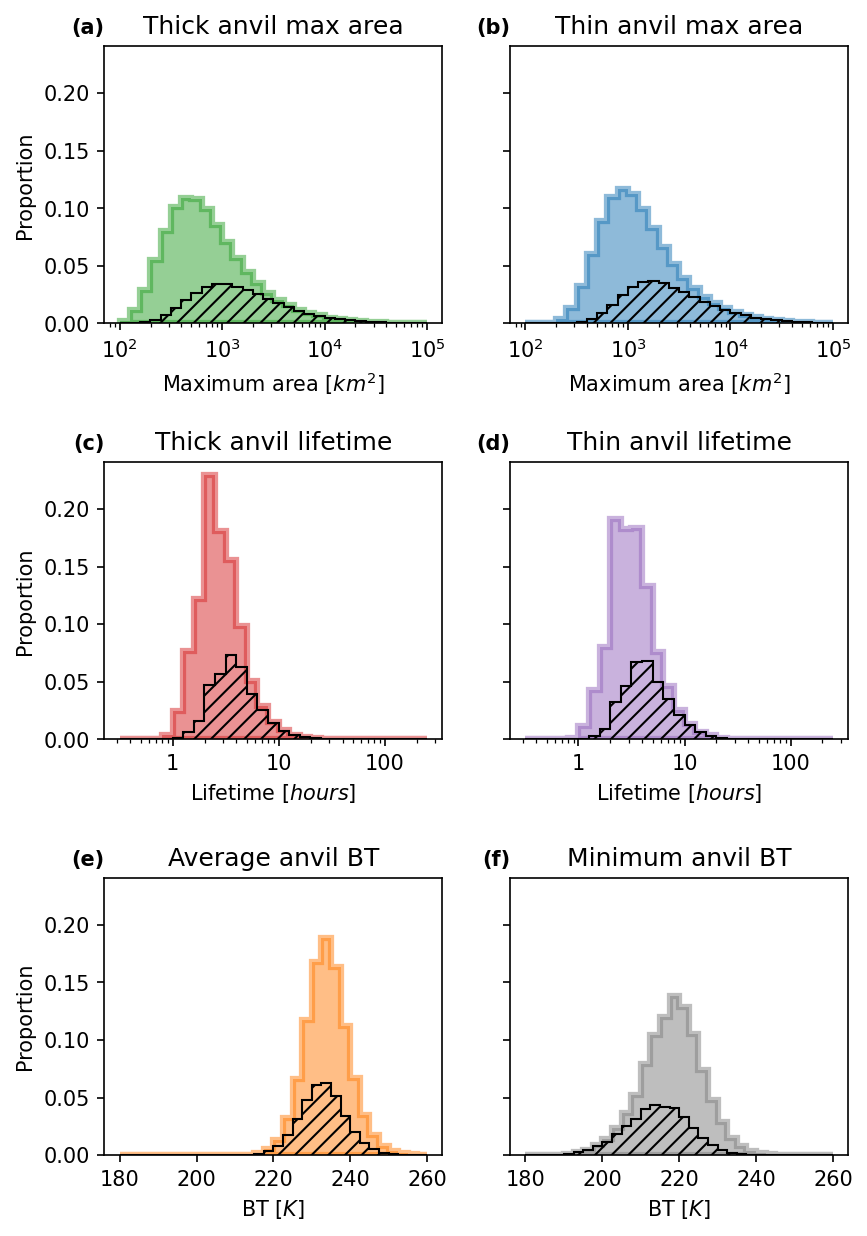

In [63]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, dpi=dpi, sharey=True, figsize=(6.4,9.6))

anvil_area_bins = 10**np.arange(2,5.1,0.1)
ax1.hist(
    anvil_max_area[anvil_is_valid], bins=anvil_area_bins, 
    weights=np.full((np.sum(anvil_is_valid),), 1/np.sum(anvil_is_valid)), 
    alpha=0.5, facecolor="C2", edgecolor="C2", ls='solid', lw=3, histtype='stepfilled'
)
ax1.hist(
    anvil_max_area[anvil_has_multiple_cores], bins=anvil_area_bins, 
    weights=np.full((np.sum(anvil_has_multiple_cores),), 1/np.sum(anvil_is_valid)), 
    histtype='step', linewidth=1, facecolor='none', 
    hatch='///', edgecolor='k', fill=True
)

ax1.set_xscale("log")
ax1.set_xlabel("Maximum area [$km^2$]")
ax1.set_ylabel("Proportion")
ax1.set_title("Thick anvil max area")
ax1.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=10)

ax2.hist(
    thin_anvil_max_area[anvil_is_valid], bins=anvil_area_bins, 
    weights=np.full((np.sum(anvil_is_valid),), 1/np.sum(anvil_is_valid)), 
    alpha=0.5, facecolor="C0", edgecolor="C0", ls='solid', lw=3, histtype='stepfilled'
)
ax2.hist(
    thin_anvil_max_area[anvil_has_multiple_cores], bins=anvil_area_bins, 
    weights=np.full((np.sum(anvil_has_multiple_cores),), 1/np.sum(anvil_is_valid)), 
    histtype='step', linewidth=1, facecolor='none', 
    hatch='///', edgecolor='k', fill=True
)

ax2.set_xscale("log")
ax2.set_xlabel("Maximum area [$km^2$]")
ax2.set_title("Thin anvil max area")
ax2.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=10)


anvil_lifetime_bins = 10**np.arange(-0.5,2.5,0.1)
ax3.hist(
    thick_anvil_lifetime[anvil_is_valid], bins=anvil_lifetime_bins, 
    weights=np.full((np.sum(anvil_is_valid),), 1/np.sum(anvil_is_valid)), 
    alpha=0.5, facecolor="C3", edgecolor="C3", ls='solid', lw=3, histtype='stepfilled'
)
ax3.hist(
    thick_anvil_lifetime[anvil_has_multiple_cores], bins=anvil_lifetime_bins, 
    weights=np.full((np.sum(anvil_has_multiple_cores),), 1/np.sum(anvil_is_valid)), 
    histtype='step', linewidth=1, facecolor='none', 
    hatch='///', edgecolor='k', fill=True
)

ax3.set_xscale("log")
ax3.set_xticks([1,10,100],[1,10,100])
ax3.set_xlabel("Lifetime [$hours$]")
ax3.set_ylabel("Proportion")
ax3.set_title("Thick anvil lifetime")
ax3.set_title("(c)", loc="left", ha="right", weight="bold", fontsize=10)

ax4.hist(
    thin_anvil_lifetime[anvil_is_valid], bins=anvil_lifetime_bins, 
    weights=np.full((np.sum(anvil_is_valid),), 1/np.sum(anvil_is_valid)), 
    alpha=0.5, facecolor="C4", edgecolor="C4", ls='solid', lw=3, histtype='stepfilled'
)
ax4.hist(
    thin_anvil_lifetime[anvil_has_multiple_cores], bins=anvil_lifetime_bins, 
    weights=np.full((np.sum(anvil_has_multiple_cores),), 1/np.sum(anvil_is_valid)), 
    histtype='step', linewidth=1, facecolor='none', 
    hatch='///', edgecolor='k', fill=True
)

ax4.set_xscale("log")
ax4.set_xticks([1,10,100],[1,10,100])
ax4.set_xlabel("Lifetime [$hours$]")
# ax4.set_ylabel("Proportion")
ax4.set_title("Thin anvil lifetime")
ax4.set_title("(d)", loc="left", ha="right", weight="bold", fontsize=10)


anvil_BT_bins = np.arange(180,261,2.5)
ax5.hist(
    anvil_ctt_mean[anvil_is_valid], bins=anvil_BT_bins, 
    weights=np.full((np.sum(anvil_is_valid),), 1/np.sum(anvil_is_valid)),   
    alpha=0.5, facecolor="C1", edgecolor="C1", ls='solid', lw=3, histtype='stepfilled'
)
ax5.hist(
    anvil_ctt_mean[anvil_has_multiple_cores], bins=anvil_BT_bins, 
    weights=np.full((np.sum(anvil_has_multiple_cores),), 1/np.sum(anvil_is_valid)), 
    histtype='step', linewidth=1, facecolor='none', 
    hatch='///', edgecolor='k', fill=True
)

ax5.set_xlabel("BT [$K$]")
ax5.set_ylabel("Proportion")
ax5.set_title("Average anvil BT")
ax5.set_title("(e)", loc="left", ha="right", weight="bold", fontsize=10)

ax6.hist(
    anvil_ctt_min[anvil_is_valid], bins=anvil_BT_bins, 
    weights=np.full((np.sum(anvil_is_valid),), 1/np.sum(anvil_is_valid)),   
    alpha=0.5, facecolor="C7", edgecolor="C7", ls='solid', lw=3, histtype='stepfilled'
)
ax6.hist(
    anvil_ctt_min[anvil_has_multiple_cores], bins=anvil_BT_bins, 
    weights=np.full((np.sum(anvil_has_multiple_cores),), 1/np.sum(anvil_is_valid)), 
    histtype='step', linewidth=1, facecolor='none', 
    hatch='///', edgecolor='k', fill=True
)

ax6.set_xlabel("BT [$K$]")
# ax6.set_ylabel("Proportion")
ax6.set_title("Minimum anvil BT")
ax6.set_title("(f)", loc="left", ha="right", weight="bold", fontsize=10)

plt.subplots_adjust(hspace=0.5)

figure_list.append(plt.gcf())

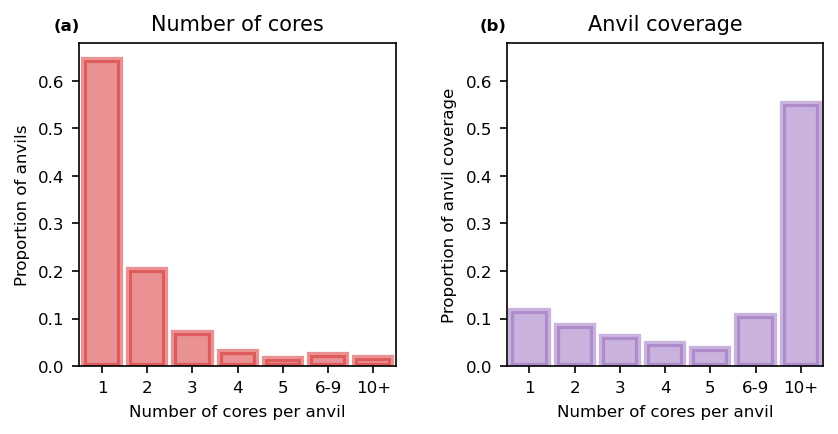

In [64]:
fig = plt.figure(dpi=dpi, figsize=(6.4,2.8))

bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 9.5, 999999]
bin_positions = [1, 2, 3, 4, 5, 6, 7]
bin_labels = [1, 2, 3, 4, 5, "6-9", "10+"]

ax3 = plt.subplot(121)

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    np.ones(anvil_number_of_cores.size)[anvil_is_valid]/np.sum(anvil_is_valid), 
    bins=bins, 
    statistic="sum"
)

ax3.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C3', edgecolor='C3', ls='solid', lw=3)

plt.xlim([0.5, 7.5])
plt.ylim([0,0.68])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=8)
plt.ylabel("Proportion of anvils", fontsize=8)
ax3.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=8)
ax3.set_title("Number of cores", fontsize=10)
ax3.tick_params(axis='both', which='major', labelsize=8)

ax4 = plt.subplot(122)

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_total_area[anvil_is_valid], 
    bins=bins, 
    statistic="sum"
)

plt.bar(bin_positions, bar_data[0]/np.sum(bar_data[0]), 
        alpha=0.5, facecolor = 'C4', edgecolor='C4', ls='solid', lw=3)

plt.xlim([0.5, 7.5])
plt.ylim([0,0.68])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=8)
plt.ylabel("Proportion of anvil coverage", fontsize=8)
ax4.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=8)
ax4.set_title("Anvil coverage", fontsize=10)
ax4.tick_params(axis='both', which='major', labelsize=8)

plt.subplots_adjust(hspace=0.35, wspace=0.35)

figure_list.append(plt.gcf())

In [65]:
for i, fig in enumerate(figure_list):
    fig.savefig(
        save_path / f'{chapter_name}_{(i+1):02d}.{save_format}',
        bbox_inches="tight", pad_inches=0.25
    )

/Users/jonesw/mambaforge-pypy3/envs/thesis_notebooks/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
